In [36]:
import numpy as np
from scipy import stats

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import time
import os

import requests
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [37]:
# read excel from path
path = r'../11_how to check nft wallet transactions/Doodles.xlsx'

df = pd.read_excel(path)

# drop duplicates   
df = df.drop_duplicates()

In [38]:
# Load API key from environment variables
api_key = os.getenv('ETHERSCAN_API_KEY')

# Verify the API key is loaded
if not api_key:
    raise ValueError("ETHERSCAN_API_KEY not found in environment variables. Please check your .env file.")
    
print("API key loaded successfully from .env file")

API key loaded successfully from .env file


In [39]:
def get_ethereum_transactions(wallet_address, api_key):
    """
    Get all transactions for a given Ethereum wallet address using Etherscan API
    """
    api_url = f"https://api.etherscan.io/v2/api?chainid=1&module=account&action=txlist&address={wallet_address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}"
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        if data['status'] == '1':
            return data['result']
        else:
            return []
    else:
        print(f"Error for wallet {wallet_address}: {response.status_code}, {response.text}")
        return []

def get_ethereum_internal_transactions(wallet_address, api_key):
    """
    Get all internal transactions for a given Ethereum wallet address using Etherscan API
    Internal transactions are contract-to-contract interactions
    """
    api_url = f"https://api.etherscan.io/v2/api?chainid=1&module=account&action=txlistinternal&address={wallet_address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}"
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        if data['status'] == '1':
            return data['result']
        else:
            return []
    else:
        print(f"Error getting internal transactions for wallet {wallet_address}: {response.status_code}, {response.text}")
        return []

In [40]:
# Doodles NFT contract address
doodles_contract_address = "0x8a90CAb2b38dba80c64b7734e58Ee1dB38B8992e"

# Space Doodles NFT contract address
space_doodles_contract_address = "0x620b70123fB810F6C653DA7644b5dD0b6312e4D8"

# Marketplace contracts for NFT trading
marketplace_contracts = [
    "0x00000000006c3852cbEf3e08E8dF289169EdE581",  # OpenSea Seaport
    "0x59728544B08AB483533076417FbBB2fD0B17CE3a",  # LooksRare
    "0x74312363e45DCaBA76c59ec49a7Aa8A65a67EeD3",  # X2Y2
    "0x000000000000Ad05Ccc4F10045630fb830B95127",  # Blur
    "0xb2ecfE4E4D61f8790bbb9DE2D1259B9e2410CEA5",  # Blur Marketplace 3
    "0x0fc584529a2AEfA997697FAfAcbA5831faC0c22d"   # NFTX nftx.io
]

# Blur Blend contracts (separate category)
blur_blend_contracts = [
    "0x29469395eAf6f95920E59F858042f0e28D98a20B",  # Blur Blend Wallet
    "0x0000000000A39bb272e79075ade125fd351887Ac"   # Blur Blend Pool
]

# Convert all addresses to lowercase for comparison
doodles_contract_address_lower = doodles_contract_address.lower()
marketplace_contracts_lower = [addr.lower() for addr in marketplace_contracts]
blur_blend_contracts_lower = [addr.lower() for addr in blur_blend_contracts]

In [41]:
def analyze_doodles_transactions(normal_transactions, internal_transactions, contract_address, marketplace_contracts, blur_blend_contracts, wallet_address):
    """
    Analyze both normal and internal transactions related to Doodles contract, marketplace contracts, and Blur Blend contracts
    tx_type: 'IN', 'OUT', 'Blend_IN', 'Blend_OUT' - based on wallet perspective
    tx_category: 'Normal', 'Internal'
    """
    contract_address_lower = contract_address.lower()
    marketplace_contracts_lower = [addr.lower() for addr in marketplace_contracts]
    blur_blend_contracts_lower = [addr.lower() for addr in blur_blend_contracts]
    wallet_address_lower = wallet_address.lower()
    doodles_txs = []
    
    # Process normal transactions
    for tx in normal_transactions:
        to_address = tx.get('to', '').lower()
        from_address = tx.get('from', '').lower()
        
        # Check if transaction involves Doodles contract, marketplace contracts, or Blur Blend contracts
        is_doodles_contract = (to_address == contract_address_lower or from_address == contract_address_lower)
        is_marketplace = (to_address in marketplace_contracts_lower or from_address in marketplace_contracts_lower)
        is_blur_blend = (to_address in blur_blend_contracts_lower or from_address in blur_blend_contracts_lower)
        
        if is_doodles_contract or is_marketplace or is_blur_blend:
            # Convert timestamp to readable date
            timestamp = int(tx.get('timeStamp', 0))
            date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
            
            # Determine transaction type based on wallet perspective
            # IN: wallet is receiving (to_address == wallet)
            # OUT: wallet is sending (from_address == wallet)
            if is_blur_blend:
                # if to_address == wallet_address_lower:
                #     tx_type = 'Blend_IN'  # Wallet receiving from Blur Blend
                # else:
                #     tx_type = 'Blend_OUT'  # Wallet sending to Blur Blend
                if to_address == wallet_address_lower:
                    tx_type = 'Blend_OUT'  # Wallet receiving from Blur Blend
                else:
                    tx_type = 'Blend_IN'  # Wallet sending to Blur Blend
                contract_type = 'Blur_Blend'
            elif is_doodles_contract:
                if to_address == wallet_address_lower:
                    tx_type = 'IN'  # Wallet receiving from Doodles contract
                else:
                    tx_type = 'OUT'  # Wallet sending to Doodles contract
                contract_type = 'Doodles'
            else:  # is_marketplace
                if to_address == wallet_address_lower:
                    tx_type = 'IN'  # Wallet receiving from marketplace
                else:
                    tx_type = 'OUT'  # Wallet sending to marketplace
                contract_type = 'Marketplace'
            
            # Add transaction without ETH value calculation (often 0 for NFTs)
            doodles_txs.append({
                'from': tx.get('from'),
                'to': tx.get('to'),
                'date': date,
                'transaction_index': tx.get('transactionIndex'),
                'input_data': tx.get('input', ''),
                'tx_type': tx_type,
                'tx_category': 'Normal',
                'contract_type': contract_type
            })
    
    # Process internal transactions (smart contract interactions)
    for tx in internal_transactions:
        to_address = tx.get('to', '').lower()
        from_address = tx.get('from', '').lower()
        
        # Check if internal transaction involves Doodles contract, marketplace contracts, or Blur Blend contracts
        is_doodles_contract = (to_address == contract_address_lower or from_address == contract_address_lower)
        is_marketplace = (to_address in marketplace_contracts_lower or from_address in marketplace_contracts_lower)
        is_blur_blend = (to_address in blur_blend_contracts_lower or from_address in blur_blend_contracts_lower)
        
        if is_doodles_contract or is_marketplace or is_blur_blend:
            # Convert timestamp to readable date
            timestamp = int(tx.get('timeStamp', 0))
            date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
            
            # Determine transaction type based on wallet perspective  
            # IN: wallet is receiving (to_address == wallet)
            # OUT: wallet is sending (from_address == wallet)
            if is_blur_blend:
                # if to_address == wallet_address_lower:
                #     tx_type = 'Blend_IN'  # Wallet receiving from Blur Blend
                # else:
                #     tx_type = 'Blend_OUT'  # Wallet sending to Blur Blend
                if to_address == wallet_address_lower:
                    tx_type = 'Blend_OUT'  # Wallet receiving from Blur Blend
                else:
                    tx_type = 'Blend_IN'  # Wallet sending to Blur Blend
                contract_type = 'Blur_Blend'
            elif is_doodles_contract:
                if to_address == wallet_address_lower:
                    tx_type = 'IN'  # Wallet receiving from Doodles contract
                else:
                    tx_type = 'OUT'  # Wallet sending to Doodles contract
                contract_type = 'Doodles'
            else:  # is_marketplace
                if to_address == wallet_address_lower:
                    tx_type = 'IN'  # Wallet receiving from marketplace
                else:
                    tx_type = 'OUT'  # Wallet sending to marketplace
                contract_type = 'Marketplace'
            
            # Add internal transaction without ETH value calculation
            doodles_txs.append({
                'from': tx.get('from'),
                'to': tx.get('to'),
                'date': date,
                'transaction_index': tx.get('transactionIndex', 'N/A'),
                'input_data': tx.get('input', ''),
                'tx_type': tx_type,
                'tx_category': 'Internal',
                'contract_type': contract_type
            })
    
    return pd.DataFrame(doodles_txs)

# Process all wallets in df.wallet
all_doodles_transactions = []
wallet_summary = []

print("Analyzing all wallets for Doodles transactions...")
print("=" * 60)

for idx, wallet_address in enumerate(df['wallet'], 1):
    print(f"Processing wallet {idx}/{len(df['wallet'])}: {wallet_address}")
    
    # Get both normal and internal transactions for current wallet
    normal_transactions = get_ethereum_transactions(wallet_address, api_key)
    internal_transactions = get_ethereum_internal_transactions(wallet_address, api_key)
    
    if normal_transactions or internal_transactions:
        # Analyze Doodles transactions from both normal and internal, including marketplaces and Blur Blend contracts
        doodles_df = analyze_doodles_transactions(normal_transactions, internal_transactions, doodles_contract_address, marketplace_contracts, blur_blend_contracts, wallet_address)
        
        if len(doodles_df) > 0:
            # Add wallet address to each transaction
            doodles_df['wallet'] = wallet_address
            all_doodles_transactions.append(doodles_df)
            
            print(f"  ✓ Found {len(doodles_df)} Doodles transactions")
            print(f"    Date range: {doodles_df['date'].min()} to {doodles_df['date'].max()}")
            
            # Add to summary with correct transaction categorization
            # tx_type: 'IN', 'OUT', 'Blend_IN', 'Blend_OUT'
            # tx_category: 'Normal', 'Internal'
            # Note: For Blur Blend, the logic is inverted:
            # - Blend_OUT = NFT exits Blend contract and goes to wallet (BUY)
            # - Blend_IN = NFT goes from wallet to Blend contract (SELL)
            
            # Count normal transactions (excluding Blend)
            normal_buy_count = len(doodles_df[doodles_df['tx_type'] == 'IN'])
            normal_sell_count = len(doodles_df[doodles_df['tx_type'] == 'OUT'])
            
            # Count Blend transactions separately
            blend_in_count = len(doodles_df[doodles_df['tx_type'] == 'Blend_IN'])  # SELL
            blend_out_count = len(doodles_df[doodles_df['tx_type'] == 'Blend_OUT'])  # BUY
            
            # Count by transaction category (Normal vs Internal)
            normal_count = len(doodles_df[doodles_df['tx_category'] == 'Normal'])
            internal_count = len(doodles_df[doodles_df['tx_category'] == 'Internal'])
            
            # Split normal transactions by type (excluding Blend)
            normal_transactions_buy_count = len(doodles_df[(doodles_df['tx_category'] == 'Normal') & 
                                                          (doodles_df['tx_type'] == 'IN')])
            normal_transactions_sell_count = len(doodles_df[(doodles_df['tx_category'] == 'Normal') & 
                                                           (doodles_df['tx_type'] == 'OUT')])
            
            # Split internal transactions by type (excluding Blend)
            internal_transactions_buy_count = len(doodles_df[(doodles_df['tx_category'] == 'Internal') & 
                                                            (doodles_df['tx_type'] == 'IN')])
            internal_transactions_sell_count = len(doodles_df[(doodles_df['tx_category'] == 'Internal') & 
                                                             (doodles_df['tx_type'] == 'OUT')])
            
            # Split Blend transactions by category
            normal_blend_in_count = len(doodles_df[(doodles_df['tx_category'] == 'Normal') & 
                                                   (doodles_df['tx_type'] == 'Blend_IN')])
            normal_blend_out_count = len(doodles_df[(doodles_df['tx_category'] == 'Normal') & 
                                                    (doodles_df['tx_type'] == 'Blend_OUT')])
            internal_blend_in_count = len(doodles_df[(doodles_df['tx_category'] == 'Internal') & 
                                                     (doodles_df['tx_type'] == 'Blend_IN')])
            internal_blend_out_count = len(doodles_df[(doodles_df['tx_category'] == 'Internal') & 
                                                      (doodles_df['tx_type'] == 'Blend_OUT')])
            
            # Get last transaction date for each type
            normal_buy_txs = doodles_df[doodles_df['tx_type'] == 'IN']
            normal_sell_txs = doodles_df[doodles_df['tx_type'] == 'OUT']
            blend_buy_txs = doodles_df[doodles_df['tx_type'] == 'Blend_OUT']  # BUY
            blend_sell_txs = doodles_df[doodles_df['tx_type'] == 'Blend_IN']  # SELL
            blend_txs = doodles_df[doodles_df['tx_type'].isin(['Blend_IN', 'Blend_OUT'])]
            normal_txs = doodles_df[doodles_df['tx_category'] == 'Normal']
            internal_txs = doodles_df[doodles_df['tx_category'] == 'Internal']
            
            wallet_summary.append({
                'wallet': wallet_address,
                'doodles_transactions': len(doodles_df),
                'normal_transactions_buy': normal_buy_count,
                'normal_transactions_sell': normal_sell_count,
                'blend_transactions_buy': blend_out_count,  # Blend_OUT = BUY
                'blend_transactions_sell': blend_in_count,  # Blend_IN = SELL
                'normal_transactions': normal_count,
                'internal_transactions': internal_count,
                'normal_transactions_buy_only': normal_transactions_buy_count,  # Normal IN only
                'normal_transactions_sell_only': normal_transactions_sell_count,  # Normal OUT only
                'internal_transactions_buy_only': internal_transactions_buy_count,  # Internal IN only
                'internal_transactions_sell_only': internal_transactions_sell_count,  # Internal OUT only
                'normal_blend_in': normal_blend_in_count,  # Normal Blend SELL
                'normal_blend_out': normal_blend_out_count,  # Normal Blend BUY
                'internal_blend_in': internal_blend_in_count,  # Internal Blend SELL
                'internal_blend_out': internal_blend_out_count,  # Internal Blend BUY
                'last_transaction': doodles_df['date'].max(),
                'last_normal_buy_transaction': normal_buy_txs['date'].max() if len(normal_buy_txs) > 0 else None,
                'last_normal_sell_transaction': normal_sell_txs['date'].max() if len(normal_sell_txs) > 0 else None,
                'last_blend_buy_transaction': blend_buy_txs['date'].max() if len(blend_buy_txs) > 0 else None,
                'last_blend_sell_transaction': blend_sell_txs['date'].max() if len(blend_sell_txs) > 0 else None,
                'last_blend_transaction': blend_txs['date'].max() if len(blend_txs) > 0 else None,
                'last_normal_transaction': normal_txs['date'].max() if len(normal_txs) > 0 else None,
                'last_internal_transaction': internal_txs['date'].max() if len(internal_txs) > 0 else None
            })
        else:
            print(f"  - No Doodles transactions found")
            wallet_summary.append({
                'wallet': wallet_address,
                'doodles_transactions': 0,
                'normal_transactions_buy': 0,
                'normal_transactions_sell': 0,
                'blend_transactions_buy': 0,
                'blend_transactions_sell': 0,
                'normal_transactions': 0,
                'internal_transactions': 0,
                'normal_transactions_buy_only': 0,
                'normal_transactions_sell_only': 0,
                'internal_transactions_buy_only': 0,
                'internal_transactions_sell_only': 0,
                'normal_blend_in': 0,
                'normal_blend_out': 0,
                'internal_blend_in': 0,
                'internal_blend_out': 0,
                'last_transaction': None,
                'last_normal_buy_transaction': None,
                'last_normal_sell_transaction': None,
                'last_blend_buy_transaction': None,
                'last_blend_sell_transaction': None,
                'last_blend_transaction': None,
                'last_normal_transaction': None,
                'last_internal_transaction': None
            })
    else:
        print(f"  ! No transactions found or API error")
        wallet_summary.append({
            'wallet': wallet_address,
            'doodles_transactions': 0,
            'normal_transactions_buy': 0,
            'normal_transactions_sell': 0,
            'blend_transactions_buy': 0,
            'blend_transactions_sell': 0,
            'normal_transactions': 0,
            'internal_transactions': 0,
            'normal_transactions_buy_only': 0,
            'normal_transactions_sell_only': 0,
            'internal_transactions_buy_only': 0,
            'internal_transactions_sell_only': 0,
            'normal_blend_in': 0,
            'normal_blend_out': 0,
            'internal_blend_in': 0,
            'internal_blend_out': 0,
            'last_transaction': None,
            'last_normal_buy_transaction': None,
            'last_normal_sell_transaction': None,
            'last_blend_buy_transaction': None,
            'last_blend_sell_transaction': None,
            'last_blend_transaction': None,
            'last_normal_transaction': None,
            'last_internal_transaction': None
        })
    
    # Add delay to respect API rate limits
    time.sleep(0.2)

print("\n" + "=" * 60)
print("SUMMARY RESULTS")
print("=" * 60)

# Create summary DataFrame
summary_df = pd.DataFrame(wallet_summary)
print(f"\nTotal wallets analyzed: {len(summary_df)}")
print(f"Wallets with Doodles transactions: {len(summary_df[summary_df['doodles_transactions'] > 0])}")
print(f"Total Doodles transactions found: {summary_df['doodles_transactions'].sum()}")
print(f"Total Blur Blend transactions (buy): {summary_df['blend_transactions_buy'].sum()}")
print(f"Total Blur Blend transactions (sell): {summary_df['blend_transactions_sell'].sum()}")
print(f"Total Blur Blend transactions (all): {summary_df['blend_transactions_buy'].sum() + summary_df['blend_transactions_sell'].sum()}")

# Combine all transactions if any found
if all_doodles_transactions:
    combined_doodles_df = pd.concat(all_doodles_transactions, ignore_index=True)
    print(f"\nCombined Doodles transactions DataFrame shape: {combined_doodles_df.shape}")
else:
    print("\nNo Doodles transactions found across all wallets")
    combined_doodles_df = pd.DataFrame()

Analyzing all wallets for Doodles transactions...
Processing wallet 1/58: 0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
  ✓ Found 233 Doodles transactions
    Date range: 2022-03-04 11:08:05 to 2024-04-28 06:58:35
Processing wallet 2/58: 0x958ab8695f33Cc5BeccBCb90B5A6c11B5f705e39
  ✓ Found 233 Doodles transactions
    Date range: 2022-03-04 11:08:05 to 2024-04-28 06:58:35
Processing wallet 2/58: 0x958ab8695f33Cc5BeccBCb90B5A6c11B5f705e39
  - No Doodles transactions found
Processing wallet 3/58: 0xA71365a3A7f4f6a9F4AC18d65Ab338E0C9708830
  - No Doodles transactions found
Processing wallet 3/58: 0xA71365a3A7f4f6a9F4AC18d65Ab338E0C9708830
  ✓ Found 771 Doodles transactions
    Date range: 2022-04-27 04:02:35 to 2025-09-23 14:57:35
Processing wallet 4/58: 0x0C37f1FC90BF56387B59615508bbd975D448856F
  ✓ Found 771 Doodles transactions
    Date range: 2022-04-27 04:02:35 to 2025-09-23 14:57:35
Processing wallet 4/58: 0x0C37f1FC90BF56387B59615508bbd975D448856F
  ✓ Found 2309 Doodles transactions
 

In [42]:
combined_doodles_df.head()

,from,to,date,transaction_index,input_data,tx_type,tx_category,contract_type,wallet
0,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x59728544b08ab483533076417fbbb2fd0b17ce3a,2022-03-04 11:08:05,152,0xb4e4b296000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
1,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-08 03:31:26,150,0xfb0f3ee1000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
2,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-24 19:55:08,82,0xb3a34c4c000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
3,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-27 07:15:22,241,0xfb0f3ee1000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
4,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-27 07:52:40,37,0xfb0f3ee1000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b


In [43]:
# normal_transactions

In [44]:
# internal_transactions

In [45]:
# Display summary table sorted by last_transaction date descending
# Convert last_transaction to datetime for proper sorting, then drop original column
summary_df['last_transaction_dt'] = pd.to_datetime(summary_df['last_transaction'], errors='coerce')
summary_df = summary_df.sort_values('last_transaction_dt', ascending=False, na_position='last')
summary_df.head(5)

,wallet,doodles_transactions,normal_transactions_buy,normal_transactions_sell,blend_transactions_buy,blend_transactions_sell,normal_transactions,internal_transactions,normal_transactions_buy_only,normal_transactions_sell_only,...,internal_blend_out,last_transaction,last_normal_buy_transaction,last_normal_sell_transaction,last_blend_buy_transaction,last_blend_sell_transaction,last_blend_transaction,last_normal_transaction,last_internal_transaction,last_transaction_dt
39,0xCc1Cb0FA339EB32E436dCe1Ba752bdA72fC6eDfe,6395,2358,2652,646,739,3391,3004,0,2652,...,646,2025-10-10 20:19:59,2025-10-10 20:19:59,2023-10-03 17:00:23,2025-10-06 23:40:23,2023-10-03 18:00:11,2025-10-06 23:40:23,2023-10-03 18:00:11,2025-10-10 20:19:59,2025-10-10 20:19:59
19,0xA2D854aC973812866A43C130717f670C16c05107,5452,58,18,4,5372,5390,62,0,18,...,4,2025-10-10 02:18:23,2025-07-13 13:07:35,2025-07-14 12:51:59,2025-05-28 11:38:47,2025-10-10 02:18:23,2025-10-10 02:18:23,2025-10-10 02:18:23,2025-07-13 13:07:35,2025-10-10 02:18:23
5,0x6cE42D8B2a202E206051bC09DBaafd1FED24d044,5728,431,305,247,4745,5050,678,0,305,...,247,2025-10-09 14:54:59,2025-09-27 19:23:35,2025-10-09 14:54:59,2025-10-07 13:28:11,2025-10-07 13:28:11,2025-10-07 13:28:11,2025-10-09 14:54:59,2025-10-07 13:28:11,2025-10-09 14:54:59
18,0xd5C4E4eD8486404DF0B22A8f72a440e8d59fedba,921,8,36,50,827,863,58,0,36,...,50,2025-10-08 19:28:11,2025-08-13 19:13:23,2025-08-09 05:52:35,2025-09-23 10:00:23,2025-10-08 19:28:11,2025-10-08 19:28:11,2025-10-08 19:28:11,2025-09-23 10:00:23,2025-10-08 19:28:11
56,0x66362B929C1a9AaF14c51aaB9B455ad7fb8268c4,824,83,651,23,67,718,106,0,651,...,23,2025-10-08 11:42:35,2025-10-02 17:46:35,2025-10-08 11:42:35,2025-08-02 07:52:11,2025-08-27 03:20:59,2025-08-27 03:20:59,2025-10-08 11:42:35,2025-10-02 17:46:35,2025-10-08 11:42:35


In [46]:
# unique values for normal_blend_in and normal_blend_out
unique_normal_blend_in = summary_df['normal_blend_in'].unique()
# unique values for normal_blend_out
unique_normal_blend_out = summary_df['normal_blend_out'].unique()

# Display unique values for normal_blend_in and normal_blend_out
print(f"\nUnique normal_blend_in values: {unique_normal_blend_in}")
print(f"Unique normal_blend_out values: {unique_normal_blend_out}")


Unique normal_blend_in values: [ 739 5372 4745  827   67  448   74    7  244   55   27  176    2  216
  464 1845   20   49 3246    0    6   73  316    1    3    5   10   16
    4   26   11   25   43]
Unique normal_blend_out values: [0]


In [47]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 39 to 32
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   wallet                           58 non-null     object        
 1   doodles_transactions             58 non-null     int64         
 2   normal_transactions_buy          58 non-null     int64         
 3   normal_transactions_sell         58 non-null     int64         
 4   blend_transactions_buy           58 non-null     int64         
 5   blend_transactions_sell          58 non-null     int64         
 6   normal_transactions              58 non-null     int64         
 7   internal_transactions            58 non-null     int64         
 8   normal_transactions_buy_only     58 non-null     int64         
 9   normal_transactions_sell_only    58 non-null     int64         
 10  internal_transactions_buy_only   58 non-null     int64         
 11 

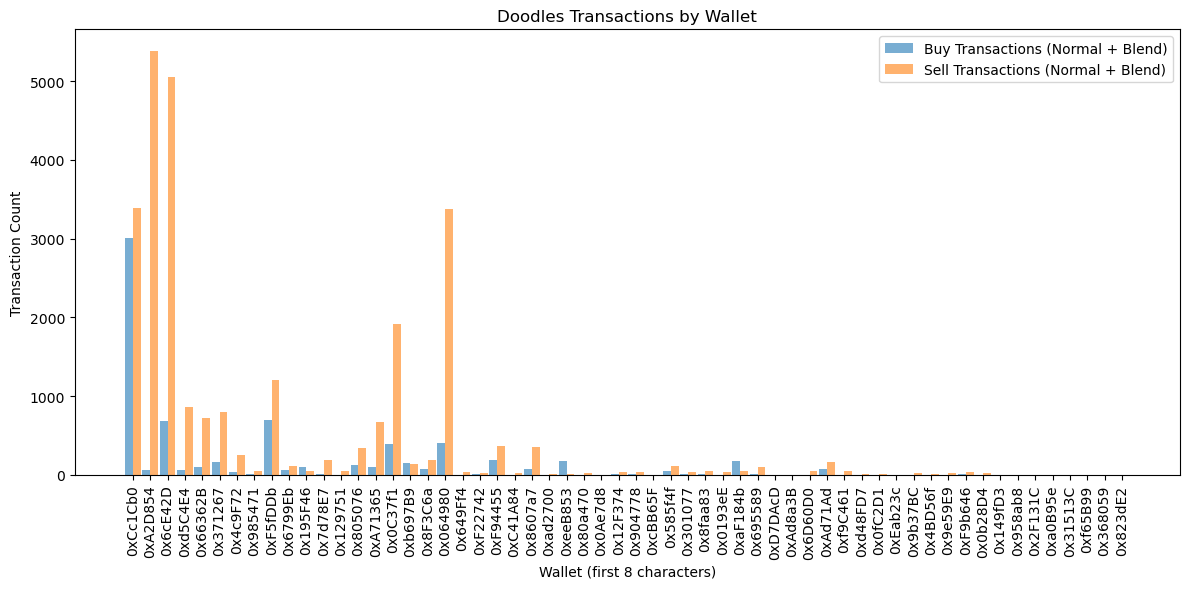

In [48]:
# plot wallets_ (df['wallet'].str[:8]) and normal_transactions_buy + blend_transactions_buy, normal_transactions_sell + blend_transactions_sell
wallets_ = summary_df['wallet'].str[:8]
# Calculate total buy and sell (normal + blend)
buy_counts = summary_df['normal_transactions_buy'] + summary_df['blend_transactions_buy']
sell_counts = summary_df['normal_transactions_sell'] + summary_df['blend_transactions_sell']

# Create separate bars for buy and sell transactions
x = range(len(wallets_))
width = 0.45

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], buy_counts, width, label='Buy Transactions (Normal + Blend)', alpha=0.6)
plt.bar([i + width/2 for i in x], sell_counts, width, label='Sell Transactions (Normal + Blend)', alpha=0.6)
plt.xlabel('Wallet (first 8 characters)')
plt.ylabel('Transaction Count')
plt.title('Doodles Transactions by Wallet')
plt.xticks(x, wallets_, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

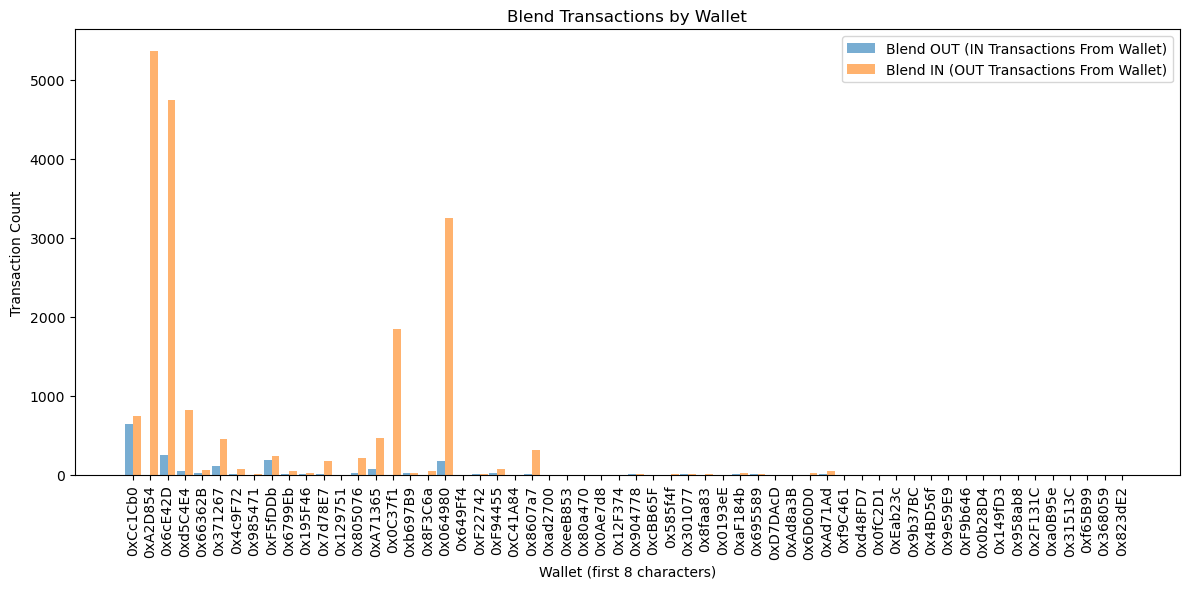

In [49]:
# plot wallet (df['wallet'].str[:8]) and blend_transactions_buy, blend_transactions_sell
blend_buy_counts = summary_df['blend_transactions_buy']
blend_sell_counts = summary_df['blend_transactions_sell']

# Create separate bars for buy and sell transactions
x = range(len(wallets_))
width = 0.45

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], blend_buy_counts, width, label='Blend OUT (IN Transactions From Wallet)', alpha=0.6)
plt.bar([i + width/2 for i in x], blend_sell_counts, width, label='Blend IN (OUT Transactions From Wallet)', alpha=0.6)
plt.xlabel('Wallet (first 8 characters)')
plt.ylabel('Transaction Count')
plt.title('Blend Transactions by Wallet')
plt.xticks(x, wallets_, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

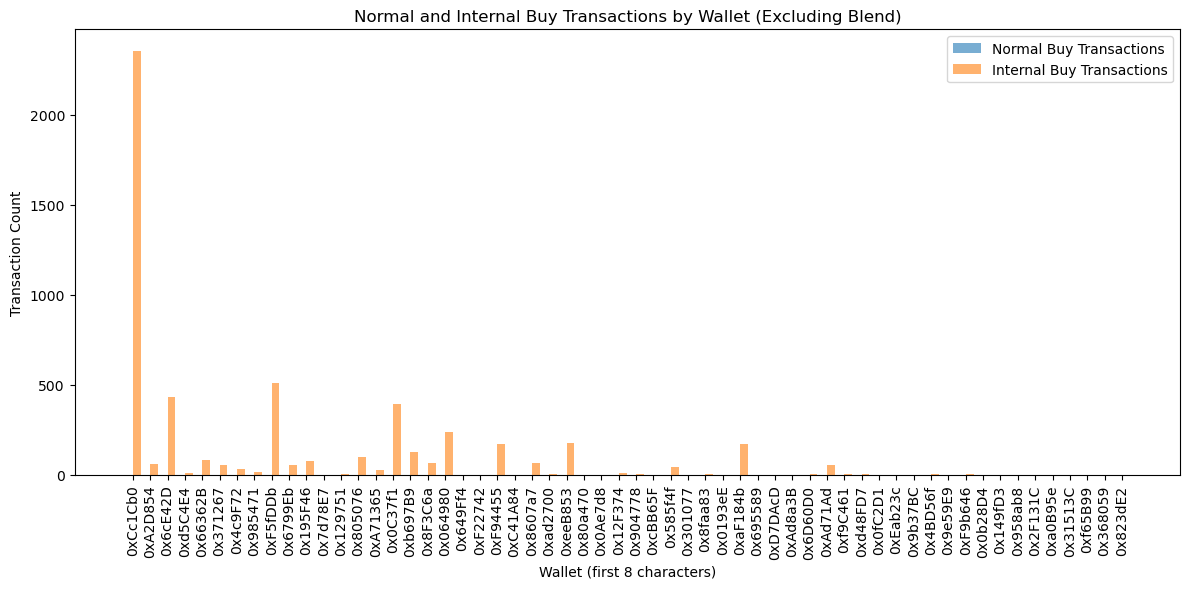

In [50]:
# plot wallets_ and normal_transactions_buy_only and internal_transactions_buy_only
normal_buy_counts = summary_df['normal_transactions_buy_only']
internal_buy_counts = summary_df['internal_transactions_buy_only']

# Create separate bars for normal and internal transactions
x = range(len(wallets_))
width = 0.45

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], normal_buy_counts, width, label='Normal Buy Transactions', alpha=0.6)
plt.bar([i + width/2 for i in x], internal_buy_counts, width, label='Internal Buy Transactions', alpha=0.6)
plt.xlabel('Wallet (first 8 characters)')
plt.ylabel('Transaction Count')
plt.title('Normal and Internal Buy Transactions by Wallet (Excluding Blend)')
plt.xticks(x, wallets_, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

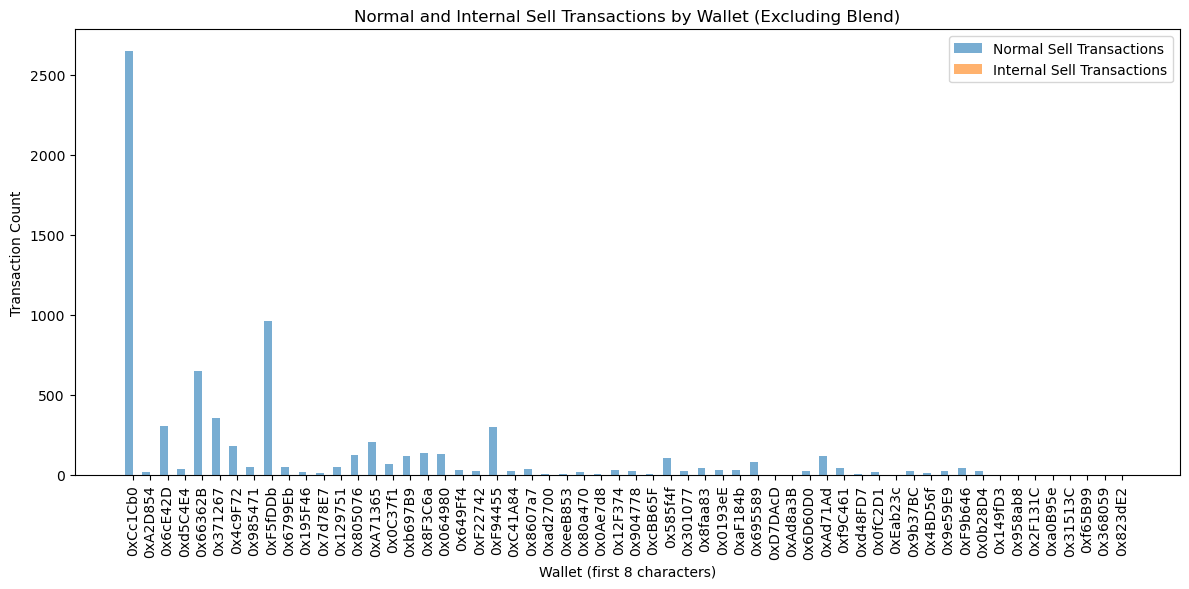

In [51]:
# plot wallets_ and normal_transactions_sell_only and internal_transactions_sell_only
normal_sell_counts = summary_df['normal_transactions_sell_only']
internal_sell_counts = summary_df['internal_transactions_sell_only']

# Create separate bars for normal and internal transactions
x = range(len(wallets_))
width = 0.45

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], normal_sell_counts, width, label='Normal Sell Transactions', alpha=0.6)
plt.bar([i + width/2 for i in x], internal_sell_counts, width, label='Internal Sell Transactions', alpha=0.6)
plt.xlabel('Wallet (first 8 characters)')
plt.ylabel('Transaction Count')
plt.title('Normal and Internal Sell Transactions by Wallet (Excluding Blend)')
plt.xticks(x, wallets_, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

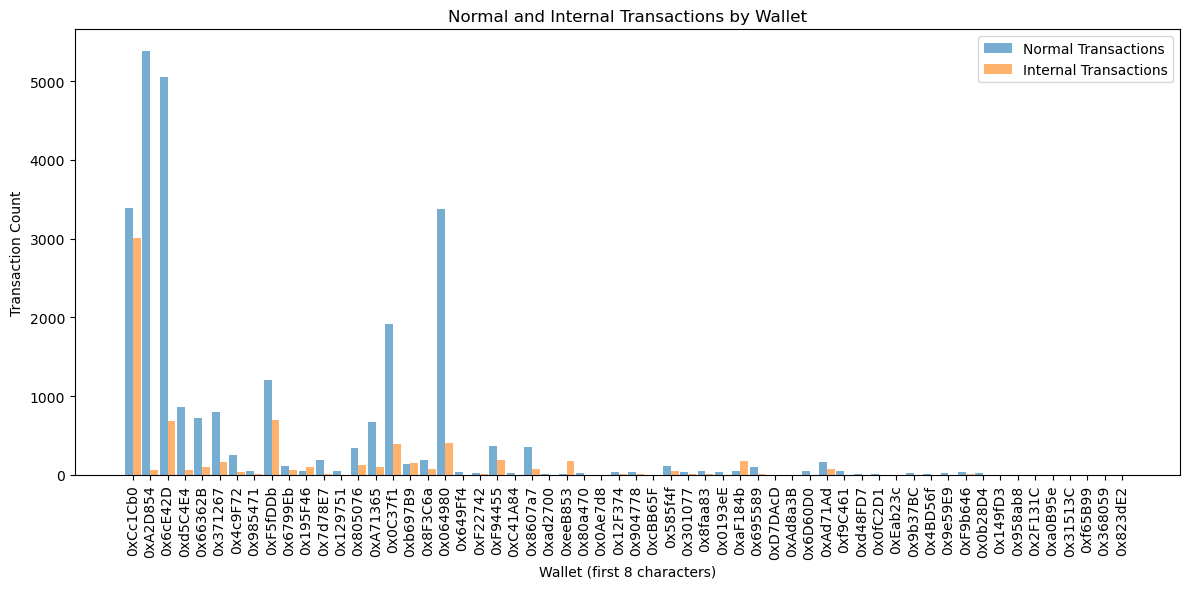

In [52]:
# plot wallets_ and normal_transactions and internal_transactions
normal_counts = summary_df['normal_transactions']
internal_counts = summary_df['internal_transactions']

# Create separate bars for normal and internal transactions
x = range(len(wallets_))
width = 0.45

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], normal_counts, width, label='Normal Transactions', alpha=0.6)
plt.bar([i + width/2 for i in x], internal_counts, width, label='Internal Transactions', alpha=0.6)
plt.xlabel('Wallet (first 8 characters)')
plt.ylabel('Transaction Count')
plt.title('Normal and Internal Transactions by Wallet')
plt.xticks(x, wallets_, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# summary_df.info()
# summary_df.shape

In [54]:
# calculate and print sum of columns for buy/sell breakdown
print("\nSummary of transaction counts:")
print(f"Total Normal transactions (buy): {summary_df['normal_transactions_buy'].sum()}")
print(f"Total Normal transactions (sell): {summary_df['normal_transactions_sell'].sum()}")
print(f"Total Blend transactions (buy): {summary_df['blend_transactions_buy'].sum()}")
print(f"Total Blend transactions (sell): {summary_df['blend_transactions_sell'].sum()}")

print(f"\nDetailed breakdown:")
print(f"Normal transactions (buy only - excluding Blend): {summary_df['normal_transactions_buy_only'].sum()}")
print(f"Normal transactions (sell only - excluding Blend): {summary_df['normal_transactions_sell_only'].sum()}")
print(f"Internal transactions (buy only - excluding Blend): {summary_df['internal_transactions_buy_only'].sum()}")
print(f"Internal transactions (sell only - excluding Blend): {summary_df['internal_transactions_sell_only'].sum()}")

print(f"\nBlend specific breakdown:")
print(f"Normal Blend IN (sell): {summary_df['normal_blend_in'].sum()}")
print(f"Normal Blend OUT (buy): {summary_df['normal_blend_out'].sum()}")
print(f"Internal Blend IN (sell): {summary_df['internal_blend_in'].sum()}")
print(f"Internal Blend OUT (buy): {summary_df['internal_blend_out'].sum()}")

print(f"\nTransactions by category:")
print(f"Total Normal transactions: {summary_df['normal_transactions'].sum()}")
print(f"Total Internal transactions: {summary_df['internal_transactions'].sum()}")

# Verification: Check if totals match
print(f"\nVerification:")
total_buy = summary_df['normal_transactions_buy'].sum() + summary_df['blend_transactions_buy'].sum()
total_sell = summary_df['normal_transactions_sell'].sum() + summary_df['blend_transactions_sell'].sum()
print(f"Total transactions = {summary_df['doodles_transactions'].sum()}")
print(f"Total buy + sell = {total_buy} + {total_sell} = {total_buy + total_sell}")
print(f"Normal + Internal = {summary_df['normal_transactions'].sum()} + {summary_df['internal_transactions'].sum()} = {summary_df['normal_transactions'].sum() + summary_df['internal_transactions'].sum()}")


Summary of transaction counts:
Total Normal transactions (buy): 5369
Total Normal transactions (sell): 7287
Total Blend transactions (buy): 1716
Total Blend transactions (sell): 19175

Detailed breakdown:
Normal transactions (buy only - excluding Blend): 0
Normal transactions (sell only - excluding Blend): 7287
Internal transactions (buy only - excluding Blend): 5369
Internal transactions (sell only - excluding Blend): 0

Blend specific breakdown:
Normal Blend IN (sell): 19175
Normal Blend OUT (buy): 0
Internal Blend IN (sell): 0
Internal Blend OUT (buy): 1716

Transactions by category:
Total Normal transactions: 26462
Total Internal transactions: 7085

Verification:
Total transactions = 33547
Total buy + sell = 7085 + 26462 = 33547
Normal + Internal = 26462 + 7085 = 33547


In [55]:
# Display wallets with their last transaction dates for each category
# Select only date-related columns for better visibility
date_columns = ['wallet', 'doodles_transactions', 'last_transaction', 'last_normal_buy_transaction', 
                'last_normal_sell_transaction', 'last_blend_buy_transaction', 'last_blend_sell_transaction',
                'last_blend_transaction', 'last_normal_transaction', 'last_internal_transaction']

summary_df[date_columns].head(10)

,wallet,doodles_transactions,last_transaction,last_normal_buy_transaction,last_normal_sell_transaction,last_blend_buy_transaction,last_blend_sell_transaction,last_blend_transaction,last_normal_transaction,last_internal_transaction
39,0xCc1Cb0FA339EB32E436dCe1Ba752bdA72fC6eDfe,6395,2025-10-10 20:19:59,2025-10-10 20:19:59,2023-10-03 17:00:23,2025-10-06 23:40:23,2023-10-03 18:00:11,2025-10-06 23:40:23,2023-10-03 18:00:11,2025-10-10 20:19:59
19,0xA2D854aC973812866A43C130717f670C16c05107,5452,2025-10-10 02:18:23,2025-07-13 13:07:35,2025-07-14 12:51:59,2025-05-28 11:38:47,2025-10-10 02:18:23,2025-10-10 02:18:23,2025-10-10 02:18:23,2025-07-13 13:07:35
5,0x6cE42D8B2a202E206051bC09DBaafd1FED24d044,5728,2025-10-09 14:54:59,2025-09-27 19:23:35,2025-10-09 14:54:59,2025-10-07 13:28:11,2025-10-07 13:28:11,2025-10-07 13:28:11,2025-10-09 14:54:59,2025-10-07 13:28:11
18,0xd5C4E4eD8486404DF0B22A8f72a440e8d59fedba,921,2025-10-08 19:28:11,2025-08-13 19:13:23,2025-08-09 05:52:35,2025-09-23 10:00:23,2025-10-08 19:28:11,2025-10-08 19:28:11,2025-10-08 19:28:11,2025-09-23 10:00:23
56,0x66362B929C1a9AaF14c51aaB9B455ad7fb8268c4,824,2025-10-08 11:42:35,2025-10-02 17:46:35,2025-10-08 11:42:35,2025-08-02 07:52:11,2025-08-27 03:20:59,2025-08-27 03:20:59,2025-10-08 11:42:35,2025-10-02 17:46:35
28,0x371267a1863080c5F39229183350e0D87d39743E,964,2025-10-07 13:31:59,2025-09-28 14:24:47,2025-09-08 11:28:59,2025-10-07 13:31:59,2025-10-07 13:31:59,2025-10-07 13:31:59,2025-10-07 13:31:59,2025-10-07 13:31:59
7,0x4c9F7207be28278b9DCA129f2e211AcfFf48Fb01,296,2025-10-07 12:42:59,2024-12-18 11:33:59,2025-10-07 12:42:59,2025-02-08 11:13:23,2025-06-08 11:40:59,2025-06-08 11:40:59,2025-10-07 12:42:59,2025-02-08 11:13:23
27,0x9854716BB75963c53c4f8cCA97B74B94Db848a71,71,2025-10-07 10:27:59,2025-04-28 23:20:59,2025-10-07 10:27:59,None,2025-04-18 11:09:47,2025-04-18 11:09:47,2025-10-07 10:27:59,2025-04-28 23:20:59
40,0xF5fDDb64c566F2709b68378fD0D0092cf947D931,1899,2025-10-07 08:31:23,2025-10-07 08:31:23,2025-10-01 07:56:47,2025-08-22 00:12:47,2025-10-03 21:04:35,2025-10-03 21:04:35,2025-10-03 21:04:35,2025-10-07 08:31:23
43,0x6799Eb21Fd024C3546c8a2e17650Df4f3BFc327C,169,2025-10-07 08:22:47,2025-10-03 12:16:59,2025-10-07 08:22:47,2025-07-17 01:04:11,2025-10-07 08:15:47,2025-10-07 08:15:47,2025-10-07 08:22:47,2025-10-03 12:16:59


In [56]:
# Display summary with new buy/sell breakdown columns including Blur Blend
buy_sell_columns = ['wallet', 'doodles_transactions', 'normal_transactions_buy', 'normal_transactions_sell',
                    'blend_transactions_buy', 'blend_transactions_sell', 'normal_transactions', 'internal_transactions',
                    'normal_transactions_buy_only', 'normal_transactions_sell_only',
                    'internal_transactions_buy_only', 'internal_transactions_sell_only']

summary_df[buy_sell_columns].head(10)

,wallet,doodles_transactions,normal_transactions_buy,normal_transactions_sell,blend_transactions_buy,blend_transactions_sell,normal_transactions,internal_transactions,normal_transactions_buy_only,normal_transactions_sell_only,internal_transactions_buy_only,internal_transactions_sell_only
39,0xCc1Cb0FA339EB32E436dCe1Ba752bdA72fC6eDfe,6395,2358,2652,646,739,3391,3004,0,2652,2358,0
19,0xA2D854aC973812866A43C130717f670C16c05107,5452,58,18,4,5372,5390,62,0,18,58,0
5,0x6cE42D8B2a202E206051bC09DBaafd1FED24d044,5728,431,305,247,4745,5050,678,0,305,431,0
18,0xd5C4E4eD8486404DF0B22A8f72a440e8d59fedba,921,8,36,50,827,863,58,0,36,8,0
56,0x66362B929C1a9AaF14c51aaB9B455ad7fb8268c4,824,83,651,23,67,718,106,0,651,83,0
28,0x371267a1863080c5F39229183350e0D87d39743E,964,54,353,109,448,801,163,0,353,54,0
7,0x4c9F7207be28278b9DCA129f2e211AcfFf48Fb01,296,30,180,12,74,254,42,0,180,30,0
27,0x9854716BB75963c53c4f8cCA97B74B94Db848a71,71,16,48,0,7,55,16,0,48,16,0
40,0xF5fDDb64c566F2709b68378fD0D0092cf947D931,1899,509,964,182,244,1208,691,0,964,509,0
43,0x6799Eb21Fd024C3546c8a2e17650Df4f3BFc327C,169,55,52,7,55,107,62,0,52,55,0


In [57]:
# summary_df.columns
# summary_df.info()
# summary_df.head(10)

In [58]:
# Filter wallets with recent Blur Blend transactions (last 6 months)

# Convert all date columns to datetime for analysis
date_cols = [
    'last_transaction',
    'last_normal_buy_transaction',
    'last_normal_sell_transaction',
    'last_blend_transaction',
    'last_normal_transaction',
    'last_internal_transaction'
]

for col in date_cols:
    summary_df[f'{col}_dt'] = pd.to_datetime(summary_df[col], errors='coerce')

# Calculate total blend transactions (buy + sell)
summary_df['total_blend_transactions'] = summary_df['blend_transactions_buy'] + summary_df['blend_transactions_sell']

# Find wallets with Blur Blend activity in the last 6 months
cutoff_date = datetime.now() - timedelta(days=180)
recent_blend = summary_df[
    (summary_df['last_blend_transaction_dt'] > cutoff_date) &
    (summary_df['total_blend_transactions'] > 0)
].sort_values('last_blend_transaction_dt', ascending=False)

print(f"Wallets with Blur Blend activity in last 6 months: {len(recent_blend)}")
recent_blend[['wallet', 'total_blend_transactions', 'blend_transactions_buy', 'blend_transactions_sell', 'last_blend_transaction']].head(10)
# recent_blend[['wallet', 'last_blend_transaction']].head(10)

Wallets with Blur Blend activity in last 6 months: 25


,wallet,total_blend_transactions,blend_transactions_buy,blend_transactions_sell,last_blend_transaction
19,0xA2D854aC973812866A43C130717f670C16c05107,5376,4,5372,2025-10-10 02:18:23
18,0xd5C4E4eD8486404DF0B22A8f72a440e8d59fedba,877,50,827,2025-10-08 19:28:11
28,0x371267a1863080c5F39229183350e0D87d39743E,557,109,448,2025-10-07 13:31:59
5,0x6cE42D8B2a202E206051bC09DBaafd1FED24d044,4992,247,4745,2025-10-07 13:28:11
43,0x6799Eb21Fd024C3546c8a2e17650Df4f3BFc327C,62,7,55,2025-10-07 08:15:47
39,0xCc1Cb0FA339EB32E436dCe1Ba752bdA72fC6eDfe,1385,646,739,2025-10-06 23:40:23
40,0xF5fDDb64c566F2709b68378fD0D0092cf947D931,426,182,244,2025-10-03 21:04:35
54,0x7d78E77a027D6e287293f56DA12E944b5D9F74bE,190,14,176,2025-10-03 16:08:11
33,0x805076bb8B11466AE76cFd2d4B67bcB69F449070,243,27,216,2025-09-26 22:49:35
2,0xA71365a3A7f4f6a9F4AC18d65Ab338E0C9708830,537,73,464,2025-09-23 14:57:35


In [59]:
# Analyze transaction patterns - show wallets with both buy and sell activity
# Calculate total buy and sell (normal + blend)
summary_df['total_buy'] = summary_df['normal_transactions_buy'] + summary_df['blend_transactions_buy']
summary_df['total_sell'] = summary_df['normal_transactions_sell'] + summary_df['blend_transactions_sell']

active_traders = summary_df[
    (summary_df['total_buy'] > 0) & 
    (summary_df['total_sell'] > 0)
].sort_values('doodles_transactions', ascending=False)

print(f"Wallets with both buy and sell activity: {len(active_traders)}")
print("\nMost active traders:")
active_traders[['wallet', 'total_buy', 'total_sell', 
                'last_normal_buy_transaction', 'last_normal_sell_transaction']].head(10)

Wallets with both buy and sell activity: 39

Most active traders:


,wallet,total_buy,total_sell,last_normal_buy_transaction,last_normal_sell_transaction
39,0xCc1Cb0FA339EB32E436dCe1Ba752bdA72fC6eDfe,3004,3391,2025-10-10 20:19:59,2023-10-03 17:00:23
5,0x6cE42D8B2a202E206051bC09DBaafd1FED24d044,678,5050,2025-09-27 19:23:35,2025-10-09 14:54:59
19,0xA2D854aC973812866A43C130717f670C16c05107,62,5390,2025-07-13 13:07:35,2025-07-14 12:51:59
9,0x064980edD7D43AbEE781f49A4e31C06Df05EcccB,410,3379,2024-10-08 20:32:23,2025-04-10 02:38:47
3,0x0C37f1FC90BF56387B59615508bbd975D448856F,396,1913,2025-03-15 11:19:59,2025-08-01 13:55:47
40,0xF5fDDb64c566F2709b68378fD0D0092cf947D931,691,1208,2025-10-07 08:31:23,2025-10-01 07:56:47
28,0x371267a1863080c5F39229183350e0D87d39743E,163,801,2025-09-28 14:24:47,2025-09-08 11:28:59
18,0xd5C4E4eD8486404DF0B22A8f72a440e8d59fedba,58,863,2025-08-13 19:13:23,2025-08-09 05:52:35
56,0x66362B929C1a9AaF14c51aaB9B455ad7fb8268c4,106,718,2025-10-02 17:46:35,2025-10-08 11:42:35
2,0xA71365a3A7f4f6a9F4AC18d65Ab338E0C9708830,101,670,2025-05-15 19:15:11,2025-07-21 07:35:23


In [60]:
active_traders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 39 to 36
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   wallet                           39 non-null     object        
 1   doodles_transactions             39 non-null     int64         
 2   normal_transactions_buy          39 non-null     int64         
 3   normal_transactions_sell         39 non-null     int64         
 4   blend_transactions_buy           39 non-null     int64         
 5   blend_transactions_sell          39 non-null     int64         
 6   normal_transactions              39 non-null     int64         
 7   internal_transactions            39 non-null     int64         
 8   normal_transactions_buy_only     39 non-null     int64         
 9   normal_transactions_sell_only    39 non-null     int64         
 10  internal_transactions_buy_only   39 non-null     int64         
 11 

In [61]:
# Show last 10 transactions from combined dataframe
combined_doodles_df.head(5)

,from,to,date,transaction_index,input_data,tx_type,tx_category,contract_type,wallet
0,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x59728544b08ab483533076417fbbb2fd0b17ce3a,2022-03-04 11:08:05,152,0xb4e4b296000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
1,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-08 03:31:26,150,0xfb0f3ee1000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
2,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-24 19:55:08,82,0xb3a34c4c000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
3,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-27 07:15:22,241,0xfb0f3ee1000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b
4,0xad71ad65d9a7e238f5d6145c92e2eeb00b6c3b1b,0x00000000006c3852cbef3e08e8df289169ede581,2022-07-27 07:52:40,37,0xfb0f3ee1000000000000000000000000000000000000...,OUT,Normal,Marketplace,0xAd71Ad65d9a7E238F5d6145c92E2eEB00b6C3b1b


From here on, review, maybe wrong

In [62]:
"""
conversion to datetime of columns with the new structure
"""
# Convert date columns to datetime format
date_columns = ['last_transaction', 'last_normal_buy_transaction', 'last_normal_sell_transaction',
                'last_blend_buy_transaction', 'last_blend_sell_transaction',
                'last_blend_transaction', 'last_normal_transaction', 'last_internal_transaction']

for col in date_columns:
    summary_df[col + '_dt'] = pd.to_datetime(summary_df[col], errors='coerce')

# drop date_columns
summary_df = summary_df.drop(columns=date_columns)

df = summary_df.copy()

# keep only 8 characters of wallet address
df['wallet'] = df['wallet'].str[:8]

df.head(10)

,wallet,doodles_transactions,normal_transactions_buy,normal_transactions_sell,blend_transactions_buy,blend_transactions_sell,normal_transactions,internal_transactions,normal_transactions_buy_only,normal_transactions_sell_only,...,last_normal_buy_transaction_dt,last_normal_sell_transaction_dt,last_blend_transaction_dt,last_normal_transaction_dt,last_internal_transaction_dt,total_blend_transactions,total_buy,total_sell,last_blend_buy_transaction_dt,last_blend_sell_transaction_dt
39,0xCc1Cb0,6395,2358,2652,646,739,3391,3004,0,2652,...,2025-10-10 20:19:59,2023-10-03 17:00:23,2025-10-06 23:40:23,2023-10-03 18:00:11,2025-10-10 20:19:59,1385,3004,3391,2025-10-06 23:40:23,2023-10-03 18:00:11
19,0xA2D854,5452,58,18,4,5372,5390,62,0,18,...,2025-07-13 13:07:35,2025-07-14 12:51:59,2025-10-10 02:18:23,2025-10-10 02:18:23,2025-07-13 13:07:35,5376,62,5390,2025-05-28 11:38:47,2025-10-10 02:18:23
5,0x6cE42D,5728,431,305,247,4745,5050,678,0,305,...,2025-09-27 19:23:35,2025-10-09 14:54:59,2025-10-07 13:28:11,2025-10-09 14:54:59,2025-10-07 13:28:11,4992,678,5050,2025-10-07 13:28:11,2025-10-07 13:28:11
18,0xd5C4E4,921,8,36,50,827,863,58,0,36,...,2025-08-13 19:13:23,2025-08-09 05:52:35,2025-10-08 19:28:11,2025-10-08 19:28:11,2025-09-23 10:00:23,877,58,863,2025-09-23 10:00:23,2025-10-08 19:28:11
56,0x66362B,824,83,651,23,67,718,106,0,651,...,2025-10-02 17:46:35,2025-10-08 11:42:35,2025-08-27 03:20:59,2025-10-08 11:42:35,2025-10-02 17:46:35,90,106,718,2025-08-02 07:52:11,2025-08-27 03:20:59
28,0x371267,964,54,353,109,448,801,163,0,353,...,2025-09-28 14:24:47,2025-09-08 11:28:59,2025-10-07 13:31:59,2025-10-07 13:31:59,2025-10-07 13:31:59,557,163,801,2025-10-07 13:31:59,2025-10-07 13:31:59
7,0x4c9F72,296,30,180,12,74,254,42,0,180,...,2024-12-18 11:33:59,2025-10-07 12:42:59,2025-06-08 11:40:59,2025-10-07 12:42:59,2025-02-08 11:13:23,86,42,254,2025-02-08 11:13:23,2025-06-08 11:40:59
27,0x985471,71,16,48,0,7,55,16,0,48,...,2025-04-28 23:20:59,2025-10-07 10:27:59,2025-04-18 11:09:47,2025-10-07 10:27:59,2025-04-28 23:20:59,7,16,55,NaT,2025-04-18 11:09:47
40,0xF5fDDb,1899,509,964,182,244,1208,691,0,964,...,2025-10-07 08:31:23,2025-10-01 07:56:47,2025-10-03 21:04:35,2025-10-03 21:04:35,2025-10-07 08:31:23,426,691,1208,2025-08-22 00:12:47,2025-10-03 21:04:35
43,0x6799Eb,169,55,52,7,55,107,62,0,52,...,2025-10-03 12:16:59,2025-10-07 08:22:47,2025-10-07 08:15:47,2025-10-07 08:22:47,2025-10-03 12:16:59,62,62,107,2025-07-17 01:04:11,2025-10-07 08:15:47


In [63]:
# Display the first 10 rows of the summary DataFrame
df.head(10)

,wallet,doodles_transactions,normal_transactions_buy,normal_transactions_sell,blend_transactions_buy,blend_transactions_sell,normal_transactions,internal_transactions,normal_transactions_buy_only,normal_transactions_sell_only,...,last_normal_buy_transaction_dt,last_normal_sell_transaction_dt,last_blend_transaction_dt,last_normal_transaction_dt,last_internal_transaction_dt,total_blend_transactions,total_buy,total_sell,last_blend_buy_transaction_dt,last_blend_sell_transaction_dt
39,0xCc1Cb0,6395,2358,2652,646,739,3391,3004,0,2652,...,2025-10-10 20:19:59,2023-10-03 17:00:23,2025-10-06 23:40:23,2023-10-03 18:00:11,2025-10-10 20:19:59,1385,3004,3391,2025-10-06 23:40:23,2023-10-03 18:00:11
19,0xA2D854,5452,58,18,4,5372,5390,62,0,18,...,2025-07-13 13:07:35,2025-07-14 12:51:59,2025-10-10 02:18:23,2025-10-10 02:18:23,2025-07-13 13:07:35,5376,62,5390,2025-05-28 11:38:47,2025-10-10 02:18:23
5,0x6cE42D,5728,431,305,247,4745,5050,678,0,305,...,2025-09-27 19:23:35,2025-10-09 14:54:59,2025-10-07 13:28:11,2025-10-09 14:54:59,2025-10-07 13:28:11,4992,678,5050,2025-10-07 13:28:11,2025-10-07 13:28:11
18,0xd5C4E4,921,8,36,50,827,863,58,0,36,...,2025-08-13 19:13:23,2025-08-09 05:52:35,2025-10-08 19:28:11,2025-10-08 19:28:11,2025-09-23 10:00:23,877,58,863,2025-09-23 10:00:23,2025-10-08 19:28:11
56,0x66362B,824,83,651,23,67,718,106,0,651,...,2025-10-02 17:46:35,2025-10-08 11:42:35,2025-08-27 03:20:59,2025-10-08 11:42:35,2025-10-02 17:46:35,90,106,718,2025-08-02 07:52:11,2025-08-27 03:20:59
28,0x371267,964,54,353,109,448,801,163,0,353,...,2025-09-28 14:24:47,2025-09-08 11:28:59,2025-10-07 13:31:59,2025-10-07 13:31:59,2025-10-07 13:31:59,557,163,801,2025-10-07 13:31:59,2025-10-07 13:31:59
7,0x4c9F72,296,30,180,12,74,254,42,0,180,...,2024-12-18 11:33:59,2025-10-07 12:42:59,2025-06-08 11:40:59,2025-10-07 12:42:59,2025-02-08 11:13:23,86,42,254,2025-02-08 11:13:23,2025-06-08 11:40:59
27,0x985471,71,16,48,0,7,55,16,0,48,...,2025-04-28 23:20:59,2025-10-07 10:27:59,2025-04-18 11:09:47,2025-10-07 10:27:59,2025-04-28 23:20:59,7,16,55,NaT,2025-04-18 11:09:47
40,0xF5fDDb,1899,509,964,182,244,1208,691,0,964,...,2025-10-07 08:31:23,2025-10-01 07:56:47,2025-10-03 21:04:35,2025-10-03 21:04:35,2025-10-07 08:31:23,426,691,1208,2025-08-22 00:12:47,2025-10-03 21:04:35
43,0x6799Eb,169,55,52,7,55,107,62,0,52,...,2025-10-03 12:16:59,2025-10-07 08:22:47,2025-10-07 08:15:47,2025-10-07 08:22:47,2025-10-03 12:16:59,62,62,107,2025-07-17 01:04:11,2025-10-07 08:15:47


6 month data - buy analysis

In [64]:
# to check
# Function NOT USED?

def get_nft_transfers_last_6_months(contract_address, api_key):
    """
    Get NFT transfers for the last 6 months using Etherscan API
    Based on: https://docs.etherscan.io/recipes/get-the-latest-moonbird-nft-transfers
    """
    # Calculate 6 months ago (6 * 30 days)
    # Calculate 8 months ago (8 * 30 days)
    six_months_ago = datetime.now() - timedelta(days=6*30)
    # Manually increased to 8 months to ensure we capture
    # six_months_ago = datetime.now() - timedelta(days=8*30)
    start_timestamp = int(six_months_ago.timestamp())
    
    # Get latest block number first
    latest_block_url = f"https://api.etherscan.io/v2/api?chainid=1&module=proxy&action=eth_blockNumber&apikey={api_key}"
    latest_response = requests.get(latest_block_url)
    
    if latest_response.status_code == 200:
        latest_block_data = latest_response.json()
        latest_block = int(latest_response.json()['result'], 16)
        print(f"Latest block: {latest_block}")
    else:
        print(f"Error getting latest block: {latest_response.status_code}")
        return []
    
    # Get NFT transfers using tokennfttx action with higher offset to get more results
    transfers_url = f"https://api.etherscan.io/v2/api?chainid=1&module=account&action=tokennfttx&contractaddress={contract_address}&startblock=0&endblock={latest_block}&page=1&offset=10000&sort=desc&apikey={api_key}"
    
    print(f"Getting NFT transfers for contract: {contract_address}")
    print(f"Time range: from {six_months_ago.strftime('%Y-%m-%d')} to now")
    
    response = requests.get(transfers_url)
    
    if response.status_code == 200:
        data = response.json()
        if data['status'] == '1':
            transfers = data['result']
            print(f"Total transfers found: {len(transfers)}")
            
            # Filter transfers from the last 6 months
            recent_transfers = []
            for transfer in transfers:
                transfer_timestamp = int(transfer['timeStamp'])
                if transfer_timestamp >= start_timestamp:
                    recent_transfers.append(transfer)
            
            print(f"Transfers in last 6 months: {len(recent_transfers)}")
            return recent_transfers
        else:
            print(f"API Error: {data.get('message', 'Unknown error')}")
            return []
    else:
        print(f"HTTP Error: {response.status_code}, {response.text}")
        return []

# Get NFT transfers for Doodles contract (with multiple pages if needed)
print("Fetching Doodles NFT transfers for the last 6 months...")

# Function to get multiple pages of transfers with reduced offset to avoid API limits
def get_all_nft_transfers(contract_address, api_key, max_pages=3):
    """
    Get NFT transfers from multiple pages to capture more transactions
    Uses offset=5000 to stay within API limits (PageNo x Offset <= 10000)
    Page 1: 1 x 5000 = 5000 ✓
    Page 2: 2 x 5000 = 10000 ✓  
    Page 3: 3 x 5000 = 15000 ❌ (will likely fail, but we try)
    Total possible transfers: up to 15000
    """
    all_transfers = []
    
    # Calculate 6 months ago for filtering
    six_months_ago = datetime.now() - timedelta(days=6*30)
    start_timestamp = int(six_months_ago.timestamp())
    
    # Get latest block number once at the beginning
    latest_block_url = f"https://api.etherscan.io/v2/api?chainid=1&module=proxy&action=eth_blockNumber&apikey={api_key}"
    latest_response = requests.get(latest_block_url)
    
    if latest_response.status_code == 200:
        latest_block = int(latest_response.json()['result'], 16)
        print(f"Latest block: {latest_block}")
    else:
        print(f"Error getting latest block: {latest_response.status_code}")
        return []
    
    for page in range(1, max_pages + 1):
        print(f"Fetching page {page} with offset 5000...")
        
        # Check if this page will exceed API limits
        api_limit_check = page * 5000
        if api_limit_check > 10000:
            print(f"Warning: Page {page} may exceed API limit (PageNo x Offset = {api_limit_check})")
        
        # Get NFT transfers for this page with reduced offset
        transfers_url = f"https://api.etherscan.io/v2/api?chainid=1&module=account&action=tokennfttx&contractaddress={contract_address}&startblock=0&endblock={latest_block}&page={page}&offset=5000&sort=desc&apikey={api_key}"
        
        response = requests.get(transfers_url)
        
        if response.status_code == 200:
            data = response.json()
            if data['status'] == '1':
                page_transfers = data['result']
                
                # Filter transfers from the last 6 months
                recent_transfers = []
                for transfer in page_transfers:
                    transfer_timestamp = int(transfer['timeStamp'])
                    if transfer_timestamp >= start_timestamp:
                        recent_transfers.append(transfer)
                
                all_transfers.extend(recent_transfers)
                print(f"Page {page}: {len(page_transfers)} total, {len(recent_transfers)} in last 6 months")
                
                # If we got fewer than 5000 results, we've reached the end of available data
                if len(page_transfers) < 5000:
                    print(f"Reached end of results at page {page} (got {len(page_transfers)} < 5000)")
                    break
                    
            else:
                # Handle API errors - some pages may fail due to limits
                error_msg = data.get('message', 'Unknown error')
                print(f"API Error on page {page}: {error_msg}")
                if "too large" in error_msg.lower() or "limit" in error_msg.lower():
                    print(f"API limit reached at page {page}, stopping here")
                    break
                else:
                    # For other errors, continue to next page
                    continue
        else:
            print(f"HTTP Error on page {page}: {response.status_code}")
            # For HTTP errors, continue to next page
            continue
        
        # Add delay between requests to respect rate limits
        time.sleep(0.2)
    
    # Remove duplicates that might occur across pages
    unique_transfers = []
    seen_hashes = set()
    for transfer in all_transfers:
        tx_hash = transfer.get('hash', '')
        if tx_hash not in seen_hashes:
            seen_hashes.add(tx_hash)
            unique_transfers.append(transfer)
    
    print(f"Removed {len(all_transfers) - len(unique_transfers)} duplicate transfers")
    return unique_transfers

doodles_transfers = get_all_nft_transfers(doodles_contract_address, api_key)
print(f"Total transfers collected: {len(doodles_transfers)}")

Fetching Doodles NFT transfers for the last 6 months...
Latest block: 23548950
Fetching page 1 with offset 5000...
Latest block: 23548950
Fetching page 1 with offset 5000...
Page 1: 5000 total, 5000 in last 6 months
Fetching page 2 with offset 5000...
Page 1: 5000 total, 5000 in last 6 months
Fetching page 2 with offset 5000...
Page 2: 5000 total, 5000 in last 6 months
Fetching page 3 with offset 5000...
Page 2: 5000 total, 5000 in last 6 months
Fetching page 3 with offset 5000...
API Error on page 3: Result window is too large, PageNo x Offset size must be less than or equal to 10000
API limit reached at page 3, stopping here
Removed 1375 duplicate transfers
Total transfers collected: 8625
API Error on page 3: Result window is too large, PageNo x Offset size must be less than or equal to 10000
API limit reached at page 3, stopping here
Removed 1375 duplicate transfers
Total transfers collected: 8625


In [65]:
# TO MODIFY
# doodles_transfers_df INCLUDE ONLY Space Doodles TRANSFERS

# doodles_transfers list to dataframe
doodles_transfers_df = pd.DataFrame(doodles_transfers)
doodles_transfers_df.head(5)

,blockNumber,timeStamp,hash,nonce,blockHash,from,contractAddress,to,tokenID,tokenName,...,tokenDecimal,transactionIndex,gas,gasPrice,gasUsed,cumulativeGasUsed,input,methodId,functionName,confirmations
0,23548749,1760116475,0xfa46b0b5032ad05ba6534bf72cccad31e44cd26b24ce...,1515,0xd49423aa6e5ed52dc5ff53cac5dcc2b97b92c491aa1e...,0xa92124622bba8fa904e3e9095e4fd32d3092d25c,0x8a90cab2b38dba80c64b7734e58ee1db38b8992e,0xe3a881cc4b7ebb4651a80f5a2c3df9656f41ca10,5325,Doodles,...,0,29,257877,3867072871,159131,5570089,deprecated,0x00000000,buyAndFree22457070633(uint256 amount),201
1,23548606,1760114699,0x42dcb5bd0197c834ce554e4d883b71b0a38e7d0e51b8...,1344,0x7e68ea7bb1493fca42eece77a260f65b07bce51ba01e...,0x6a1409fe3a4a9ec17552db96d2b82c2d21bda86a,0x8a90cab2b38dba80c64b7734e58ee1db38b8992e,0x96e4a596087b811d61216684a4d87c688c6cbffa,3339,Doodles,...,0,163,235111,2931135663,202263,13409269,deprecated,0xe7acab24,JunionWasHereXD_ufpfzhujazyn(),344
2,23548376,1760111939,0xcd0c72f8e7b70efb8e9ffa4564dddeff5499cc66cee4...,634,0xb3cfc2e3ea51b89d0bc086a1913ff2552c9c312fb90a...,0xf65b99ce6dc5f6c556172bcc0ff27d3665a7d9a8,0x8a90cab2b38dba80c64b7734e58ee1db38b8992e,0x8d9e8d8a684e75586ba36d9fbabf851c2bf55531,589,Doodles,...,0,77,223312,11736635534,128394,17531762,deprecated,0x08910dce,,574
3,23548293,1760110931,0x34bb254123c99306754d355ee24c2ca05083ce56d34a...,991,0x94a7fd38b7e4d54288d31b81499831ec58dcf0625b21...,0x1642a666dc6ef40535d7063e98e63a92135a5b3e,0x8a90cab2b38dba80c64b7734e58ee1db38b8992e,0xa563df990d0a84a23cb4d08b508fe156e97a5593,9695,Doodles,...,0,300,242879,16865741007,161919,23048322,deprecated,0x00000000,buyAndFree22457070633(uint256 amount),657
4,23548261,1760110547,0xba9f42fb23a07d2d7819525b7115ebb2d8d6259a3fd6...,1174,0xfe94cc13dcd67f823e78cdda721eef1c70b70dd50fa6...,0x80915e085e15c798332f825b9bf236cd2808a5af,0x8a90cab2b38dba80c64b7734e58ee1db38b8992e,0xa9768ed75d5245d71dcced3b783273ba7d4bb959,472,Doodles,...,0,70,232625,11355126169,217315,22906652,deprecated,0xe7acab24,JunionWasHereXD_ufpfzhujazyn(),689


In [66]:
doodles_transfers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8625 entries, 0 to 8624
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   blockNumber        8625 non-null   object
 1   timeStamp          8625 non-null   object
 2   hash               8625 non-null   object
 3   nonce              8625 non-null   object
 4   blockHash          8625 non-null   object
 5   from               8625 non-null   object
 6   contractAddress    8625 non-null   object
 7   to                 8625 non-null   object
 8   tokenID            8625 non-null   object
 9   tokenName          8625 non-null   object
 10  tokenSymbol        8625 non-null   object
 11  tokenDecimal       8625 non-null   object
 12  transactionIndex   8625 non-null   object
 13  gas                8625 non-null   object
 14  gasPrice           8625 non-null   object
 15  gasUsed            8625 non-null   object
 16  cumulativeGasUsed  8625 non-null   object


In [67]:
# doodles_transfers_df to csv
doodles_transfers_df.to_csv('doodles_transfers_last_6_months.csv', index=False)

In [68]:
# # min and max timestamp of doodles_transfers_df
# min_timestamp = doodles_transfers_df['timeStamp'].min()
# max_timestamp = doodles_transfers_df['timeStamp'].max()

# # Convert timestamps to datetime
# min_date = datetime.fromtimestamp(int(min_timestamp)).strftime('%Y-%m-%d %H:%M:%S')
# max_date = datetime.fromtimestamp(int(max_timestamp)).strftime('%Y-%m-%d %H:%M:%S')

# # Print min and max dates
# print(f"Min transfer date: {min_date}") 
# print(f"Max transfer date: {max_date}")

In [69]:
# Process NFT transfers to identify purchases
def process_nft_transfers_for_purchases(transfers, marketplace_contracts, blur_blend_contracts):
    """
    Process NFT transfers to identify purchases (non-zero value transfers or marketplace activity)
    Exclude transfers to blur_blend_contracts as they are not actual purchases
    """
    purchases = []
    
    # Convert to lowercase for comparison
    marketplace_contracts_lower = [addr.lower() for addr in marketplace_contracts]
    blur_blend_contracts_lower = [addr.lower() for addr in blur_blend_contracts]
    
    for transfer in transfers:
        # Convert timestamp to datetime
        timestamp = int(transfer['timeStamp'])
        transfer_date = datetime.fromtimestamp(timestamp)
        
        # Extract relevant information
        from_address = transfer['from'].lower()
        to_address = transfer['to'].lower()
        token_id = transfer['tokenID']  # Etherscan API uses 'tokenID' with capital D
        
        # Skip mints (from 0x0 address)
        if from_address == '0x0000000000000000000000000000000000000000':
            continue
        
        # Skip transfers to blur_blend_contracts (these are not purchases)
        if to_address in blur_blend_contracts_lower or from_address in blur_blend_contracts_lower:
            continue
        
        # Consider it a purchase if:
        # 1. It's not a mint (from address is not 0x0) - already checked
        # 2. It's not a blur blend transaction - already checked
        # 3. It involves marketplace activity OR direct transfers
        
        # Check if it's a marketplace-related transaction
        is_marketplace_transaction = (
            from_address in marketplace_contracts_lower or 
            to_address in marketplace_contracts_lower
        )
        
        # Add all valid transfers (marketplace and direct transfers)
        purchases.append({
            'date': transfer_date.strftime('%Y-%m-%d'),
            'datetime': transfer_date,
            'from_address': from_address,
            'to_address': to_address,
            'token_id': token_id,
            'transaction_hash': transfer['hash'],
            'block_number': int(transfer['blockNumber']),
            'is_marketplace': is_marketplace_transaction
        })
    
    return purchases

# Process transfers to identify purchases
if doodles_transfers:
    print("Processing NFT transfers to identify purchases...")
    nft_purchases = process_nft_transfers_for_purchases(doodles_transfers, marketplace_contracts, blur_blend_contracts)
    
    # Create DataFrame
    purchases_df = pd.DataFrame(nft_purchases)
    
    if len(purchases_df) > 0:
        print(f"Total NFT purchases identified: {len(purchases_df)}")
        print(f"Date range: {purchases_df['date'].min()} to {purchases_df['date'].max()}")
        
        # Show marketplace vs direct transfers breakdown
        marketplace_count = len(purchases_df[purchases_df['is_marketplace'] == True])
        direct_count = len(purchases_df[purchases_df['is_marketplace'] == False])
        print(f"Marketplace transfers: {marketplace_count}")
        print(f"Direct transfers: {direct_count}")
        
        # Display sample of purchases
        print("\nSample of NFT purchases:")
        print(purchases_df.head())
    else:
        print("No NFT purchases found in the specified time period")
        purchases_df = pd.DataFrame()
else:
    print("No transfers data to process")
    purchases_df = pd.DataFrame()

Processing NFT transfers to identify purchases...
Total NFT purchases identified: 5682
Date range: 2025-05-29 to 2025-10-10
Marketplace transfers: 0
Direct transfers: 5682

Sample of NFT purchases:
         date            datetime                                from_address  \
0  2025-10-10 2025-10-10 20:14:35  0xa92124622bba8fa904e3e9095e4fd32d3092d25c   
1  2025-10-10 2025-10-10 19:44:59  0x6a1409fe3a4a9ec17552db96d2b82c2d21bda86a   
2  2025-10-10 2025-10-10 18:58:59  0xf65b99ce6dc5f6c556172bcc0ff27d3665a7d9a8   
3  2025-10-10 2025-10-10 18:42:11  0x1642a666dc6ef40535d7063e98e63a92135a5b3e   
4  2025-10-10 2025-10-10 18:35:47  0x80915e085e15c798332f825b9bf236cd2808a5af   

                                   to_address token_id  \
0  0xe3a881cc4b7ebb4651a80f5a2c3df9656f41ca10     5325   
1  0x96e4a596087b811d61216684a4d87c688c6cbffa     3339   
2  0x8d9e8d8a684e75586ba36d9fbabf851c2bf55531      589   
3  0xa563df990d0a84a23cb4d08b508fe156e97a5593     9695   
4  0xa9768ed75d5245d71dcc

In [70]:
purchases_df.head(5)

,date,datetime,from_address,to_address,token_id,transaction_hash,block_number,is_marketplace
0,2025-10-10,2025-10-10 20:14:35,0xa92124622bba8fa904e3e9095e4fd32d3092d25c,0xe3a881cc4b7ebb4651a80f5a2c3df9656f41ca10,5325,0xfa46b0b5032ad05ba6534bf72cccad31e44cd26b24ce...,23548749,False
1,2025-10-10,2025-10-10 19:44:59,0x6a1409fe3a4a9ec17552db96d2b82c2d21bda86a,0x96e4a596087b811d61216684a4d87c688c6cbffa,3339,0x42dcb5bd0197c834ce554e4d883b71b0a38e7d0e51b8...,23548606,False
2,2025-10-10,2025-10-10 18:58:59,0xf65b99ce6dc5f6c556172bcc0ff27d3665a7d9a8,0x8d9e8d8a684e75586ba36d9fbabf851c2bf55531,589,0xcd0c72f8e7b70efb8e9ffa4564dddeff5499cc66cee4...,23548376,False
3,2025-10-10,2025-10-10 18:42:11,0x1642a666dc6ef40535d7063e98e63a92135a5b3e,0xa563df990d0a84a23cb4d08b508fe156e97a5593,9695,0x34bb254123c99306754d355ee24c2ca05083ce56d34a...,23548293,False
4,2025-10-10,2025-10-10 18:35:47,0x80915e085e15c798332f825b9bf236cd2808a5af,0xa9768ed75d5245d71dcced3b783273ba7d4bb959,472,0xba9f42fb23a07d2d7819525b7115ebb2d8d6259a3fd6...,23548261,False


In [71]:
# # download to excel file purchases_df
# purchases_df.to_csv('doodles_nft_purchases.csv', index=False)
# print("Doodles NFT purchases saved to 'doodles_nft_purchases.csv'")

In [72]:
# errore

# count unique values of is_marketplace
marketplace_counts = purchases_df['is_marketplace'].value_counts()
marketplace_counts

is_marketplace
False    5682
Name: count, dtype: int64

In [73]:
# Aggregate purchases by day
if len(purchases_df) > 0:
    print("Aggregating purchases by day...")
    
    # Group by date and count purchases
    daily_purchases = purchases_df.groupby('date').agg({
        'token_id': 'count',  # Count of purchases per day
        'transaction_hash': 'nunique'  # Unique transactions per day
    }).reset_index()
    
    # Rename columns for clarity
    daily_purchases.columns = ['date', 'nft_purchases_count', 'unique_transactions']
    
    # Convert date to datetime for proper sorting
    daily_purchases['date_dt'] = pd.to_datetime(daily_purchases['date'])
    daily_purchases = daily_purchases.sort_values('date_dt')
    
    # Display summary
    print(f"Total days with NFT purchases: {len(daily_purchases)}")
    print(f"Total NFT purchases: {daily_purchases['nft_purchases_count'].sum()}")
    print(f"Average purchases per day: {daily_purchases['nft_purchases_count'].mean():.2f}")
    print(f"Max purchases in a single day: {daily_purchases['nft_purchases_count'].max()}")
    
    # Calculate rolling averages (30 days)
    daily_purchases['rolling_30d_avg'] = daily_purchases['nft_purchases_count'].rolling(window=30, min_periods=1).mean()
    daily_purchases['rolling_30d_sum'] = daily_purchases['nft_purchases_count'].rolling(window=30, min_periods=1).sum()
    daily_purchases['rolling_30d_max'] = daily_purchases['nft_purchases_count'].rolling(window=30, min_periods=1).max()
    
    print(f"\nRolling 30-day metrics:")
    print(f"Current 30-day average: {daily_purchases['rolling_30d_avg'].iloc[-1]:.2f}")
    print(f"Current 30-day total: {daily_purchases['rolling_30d_sum'].iloc[-1]:.0f}")
    print(f"Current 30-day max: {daily_purchases['rolling_30d_max'].iloc[-1]:.0f}")
    
    # Display top 10 days by purchase activity
    print("\nTop 10 days by NFT purchase activity:")
    top_purchase_days = daily_purchases.nlargest(10, 'nft_purchases_count')
    print(top_purchase_days[['date', 'nft_purchases_count', 'unique_transactions']])
    
    # Display recent activity
    print("\nMost recent 10 days with purchases:")
    recent_purchases = daily_purchases.tail(10)
    print(recent_purchases[['date', 'nft_purchases_count', 'unique_transactions']])
    
else:
    print("No purchases data to aggregate")
    daily_purchases = pd.DataFrame()

Aggregating purchases by day...
Total days with NFT purchases: 135
Total NFT purchases: 5682
Average purchases per day: 42.09
Max purchases in a single day: 172

Rolling 30-day metrics:
Current 30-day average: 60.30
Current 30-day total: 1809
Current 30-day max: 172

Top 10 days by NFT purchase activity:
           date  nft_purchases_count  unique_transactions
131  2025-10-07                  172                  172
119  2025-09-25                  142                  142
128  2025-10-04                  137                  137
133  2025-10-09                  137                  137
121  2025-09-27                  125                  125
130  2025-10-06                  124                  124
59   2025-07-27                  114                  114
53   2025-07-21                  110                  110
60   2025-07-28                   88                   88
122  2025-09-28                   84                   84

Most recent 10 days with purchases:
           date  nf

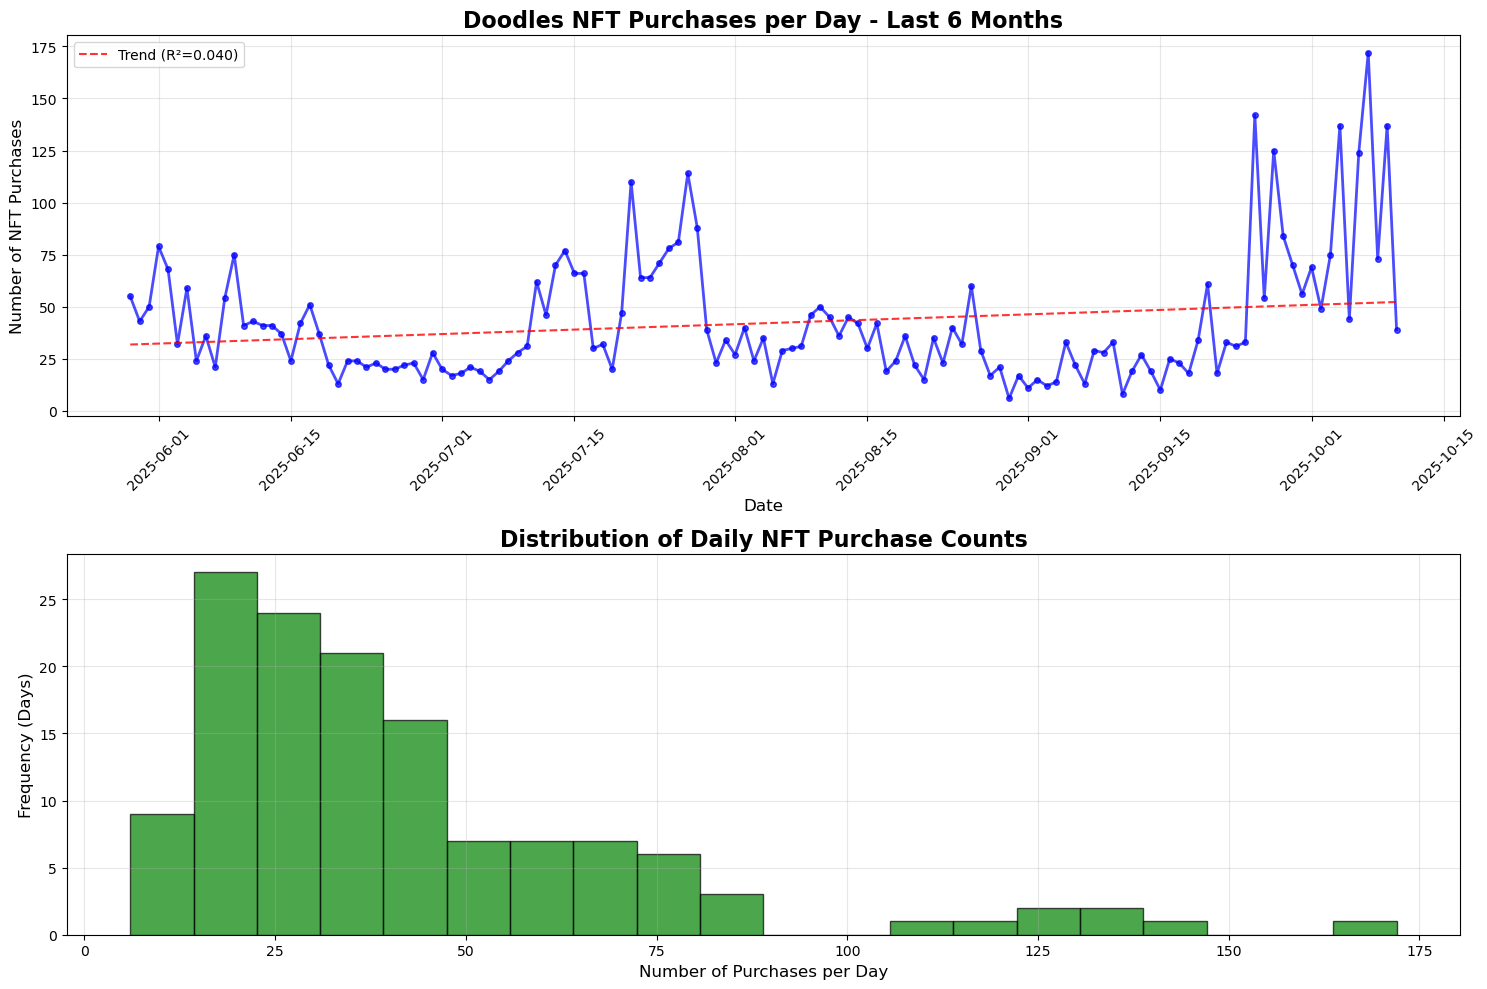


Trend Analysis:
Slope: 0.1524 (purchases per day change)
R-squared: 0.0397 (trend strength)
P-value: 0.0205
📈 Trend: INCREASING purchase activity


In [74]:
# Visualize daily NFT purchases trend
if len(daily_purchases) > 0:
    
    # Create the trend visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Daily NFT purchases over time
    ax1.plot(daily_purchases['date_dt'], daily_purchases['nft_purchases_count'], 
             marker='o', linewidth=2, markersize=4, color='blue', alpha=0.7)
    ax1.set_title('Doodles NFT Purchases per Day - Last 6 Months', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Number of NFT Purchases', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add trend line
    x_numeric = range(len(daily_purchases))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, daily_purchases['nft_purchases_count'])
    trend_line = slope * np.array(x_numeric) + intercept
    ax1.plot(daily_purchases['date_dt'], trend_line, '--', color='red', alpha=0.8, label=f'Trend (R²={r_value**2:.3f})')
    ax1.legend()
    
    # Plot 2: Distribution of daily purchases (histogram)
    ax2.hist(daily_purchases['nft_purchases_count'], bins=20, alpha=0.7, color='green', edgecolor='black')
    ax2.set_title('Distribution of Daily NFT Purchase Counts', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Number of Purchases per Day', fontsize=12)
    ax2.set_ylabel('Frequency (Days)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print(f"\nTrend Analysis:")
    print(f"Slope: {slope:.4f} (purchases per day change)")
    print(f"R-squared: {r_value**2:.4f} (trend strength)")
    print(f"P-value: {p_value:.4f}")
    
    if slope > 0:
        print("📈 Trend: INCREASING purchase activity")
    elif slope < 0:
        print("📉 Trend: DECREASING purchase activity")
    else:
        print("📊 Trend: STABLE purchase activity")
        
else:
    print("No data available for visualization")
    


In [75]:
daily_purchases.tail(5)

,date,nft_purchases_count,unique_transactions,date_dt,rolling_30d_avg,rolling_30d_sum,rolling_30d_max
130,2025-10-06,124,124,2025-10-06,49.700000,1491.0,142.0
131,2025-10-07,172,172,2025-10-07,55.000000,1650.0,172.0
132,2025-10-08,73,73,2025-10-08,56.466667,1694.0,172.0
133,2025-10-09,137,137,2025-10-09,60.100000,1803.0,172.0
134,2025-10-10,39,39,2025-10-10,60.300000,1809.0,172.0


In [76]:
daily_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 135 non-null    object        
 1   nft_purchases_count  135 non-null    int64         
 2   unique_transactions  135 non-null    int64         
 3   date_dt              135 non-null    datetime64[ns]
 4   rolling_30d_avg      135 non-null    float64       
 5   rolling_30d_sum      135 non-null    float64       
 6   rolling_30d_max      135 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 7.5+ KB


In [77]:
# Export daily purchases data and create final report
if len(daily_purchases) > 0:
    # Create a complete date range for the last 6 months
    six_months_ago = datetime.now() - timedelta(days=6*30)
    date_range = pd.date_range(start=six_months_ago.date(), end=datetime.now().date(), freq='D')
    
    # Create complete daily purchases DataFrame with zero-fill
    complete_daily_df = pd.DataFrame({'date': date_range.date})
    complete_daily_df['date'] = complete_daily_df['date'].astype(str)
    
    # Merge with actual purchases data
    complete_daily_df = complete_daily_df.merge(
        daily_purchases[['date', 'nft_purchases_count', 'unique_transactions']], 
        on='date', 
        how='left'
    )
    
    # Fill NaN values with 0 (days with no purchases)
    complete_daily_df['nft_purchases_count'] = complete_daily_df['nft_purchases_count'].fillna(0)
    complete_daily_df['unique_transactions'] = complete_daily_df['unique_transactions'].fillna(0)
    
    # Convert to int
    complete_daily_df['nft_purchases_count'] = complete_daily_df['nft_purchases_count'].astype(int)
    complete_daily_df['unique_transactions'] = complete_daily_df['unique_transactions'].astype(int)
    
    # Add day of week and other useful columns
    complete_daily_df['date_dt'] = pd.to_datetime(complete_daily_df['date'])
    complete_daily_df['day_of_week'] = complete_daily_df['date_dt'].dt.day_name()
    complete_daily_df['week_number'] = complete_daily_df['date_dt'].dt.isocalendar().week
    complete_daily_df['month'] = complete_daily_df['date_dt'].dt.month_name()
    
    print("Complete daily purchases dataset created!")
    print(f"Total days covered: {len(complete_daily_df)}")
    print(f"Days with purchases: {len(complete_daily_df[complete_daily_df['nft_purchases_count'] > 0])}")
    print(f"Days with zero purchases: {len(complete_daily_df[complete_daily_df['nft_purchases_count'] == 0])}")
    
    # Weekly aggregation
    weekly_purchases = complete_daily_df.groupby('week_number').agg({
        'nft_purchases_count': 'sum',
        'unique_transactions': 'sum'
    }).reset_index()
    
    print(f"\nWeekly Summary:")
    print(f"Average purchases per week: {weekly_purchases['nft_purchases_count'].mean():.2f}")
    print(f"Best week: {weekly_purchases['nft_purchases_count'].max()} purchases")
    print(f"Worst week: {weekly_purchases['nft_purchases_count'].min()} purchases")
    
    # Monthly aggregation
    monthly_purchases = complete_daily_df.groupby('month').agg({
        'nft_purchases_count': 'sum',
        'unique_transactions': 'sum'
    }).reset_index()
    
    print(f"\nMonthly Summary:")
    print(monthly_purchases)
    
    # Save to CSV for further analysis
    complete_daily_df.to_csv('doodles_daily_purchases_6months.csv', index=False)
    print(f"\n💾 Data exported to: doodles_daily_purchases_6months.csv")
    
    # Display final summary
    print(f"\n" + "="*50)
    print(f"FINAL REPORT - Doodles NFT Purchases (Last 6 Months)")
    print(f"="*50)
    print(f"📊 Total NFT Purchases: {complete_daily_df['nft_purchases_count'].sum()}")
    print(f"📅 Analysis Period: {complete_daily_df['date'].min()} to {complete_daily_df['date'].max()}")
    print(f"📈 Average purchases per day: {complete_daily_df['nft_purchases_count'].mean():.2f}")
    print(f"🏆 Best day: {complete_daily_df.loc[complete_daily_df['nft_purchases_count'].idxmax(), 'date']} ({complete_daily_df['nft_purchases_count'].max()} purchases)")
    print(f"📉 Days with zero purchases: {len(complete_daily_df[complete_daily_df['nft_purchases_count'] == 0])}")
    
else:
    print("No daily purchases data available for export")
    complete_daily_df = pd.DataFrame()

Complete daily purchases dataset created!
Total days covered: 181
Days with purchases: 135
Days with zero purchases: 46

Weekly Summary:
Average purchases per week: 210.44
Best week: 582 purchases
Worst week: 0 purchases

Monthly Summary:
       month  nft_purchases_count  unique_transactions
0      April                    0                    0
1     August                  961                  961
2       July                 1494                 1494
3       June                 1060                 1060
4        May                  148                  148
5    October                  919                  919
6  September                 1100                 1100

💾 Data exported to: doodles_daily_purchases_6months.csv

FINAL REPORT - Doodles NFT Purchases (Last 6 Months)
📊 Total NFT Purchases: 5682
📅 Analysis Period: 2025-04-13 to 2025-10-10
📈 Average purchases per day: 31.39
🏆 Best day: 2025-10-07 (172 purchases)
📉 Days with zero purchases: 46


In [78]:
complete_daily_df.tail()

,date,nft_purchases_count,unique_transactions,date_dt,day_of_week,week_number,month
176,2025-10-06,124,124,2025-10-06,Monday,41,October
177,2025-10-07,172,172,2025-10-07,Tuesday,41,October
178,2025-10-08,73,73,2025-10-08,Wednesday,41,October
179,2025-10-09,137,137,2025-10-09,Thursday,41,October
180,2025-10-10,39,39,2025-10-10,Friday,41,October


In [79]:
# Display the complete daily purchases dataset
if len(complete_daily_df) > 0:
    print("Sample of complete daily purchases dataset:")
    print("\nMost recent 10 days:")
    print(complete_daily_df.tail(10)[['date', 'nft_purchases_count', 'unique_transactions', 'day_of_week']])
    
    print("\nDays with highest purchase activity:")
    top_days = complete_daily_df.nlargest(10, 'nft_purchases_count')
    print(top_days[['date', 'nft_purchases_count', 'unique_transactions', 'day_of_week']])
    
    # Show day of week analysis
    dow_analysis = complete_daily_df.groupby('day_of_week').agg({
        'nft_purchases_count': ['sum', 'mean', 'max']
    }).round(2)
    
    print(f"\nDay of Week Analysis:")
    print(dow_analysis)
    
else:
    print("No complete daily data available to display")

Sample of complete daily purchases dataset:

Most recent 10 days:
           date  nft_purchases_count  unique_transactions day_of_week
171  2025-10-01                   69                   69   Wednesday
172  2025-10-02                   49                   49    Thursday
173  2025-10-03                   75                   75      Friday
174  2025-10-04                  137                  137    Saturday
175  2025-10-05                   44                   44      Sunday
176  2025-10-06                  124                  124      Monday
177  2025-10-07                  172                  172     Tuesday
178  2025-10-08                   73                   73   Wednesday
179  2025-10-09                  137                  137    Thursday
180  2025-10-10                   39                   39      Friday

Days with highest purchase activity:
           date  nft_purchases_count  unique_transactions day_of_week
177  2025-10-07                  172                  17

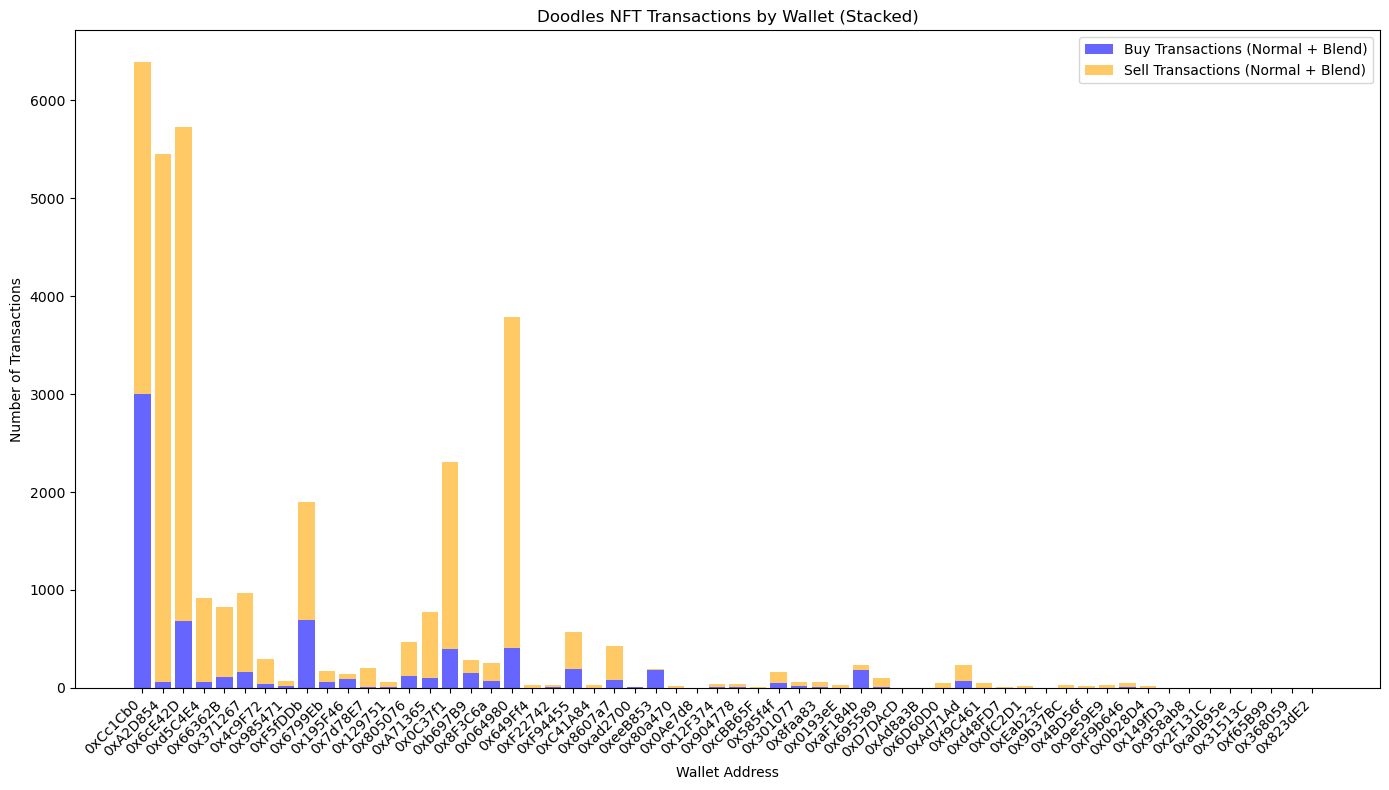

In [80]:
# plot barchart of total buy and sell transactions (normal + blend)
# Calculate total buy and sell for df DataFrame
df['total_buy'] = df['normal_transactions_buy'] + df['blend_transactions_buy']
df['total_sell'] = df['normal_transactions_sell'] + df['blend_transactions_sell']

# Plotting the bar chart for buy and sell transactions
plt.figure(figsize=(14, 8))
plt.bar(df['wallet'], df['total_buy'], label='Buy Transactions (Normal + Blend)', color='blue', alpha=0.6)
plt.bar(df['wallet'], df['total_sell'], label='Sell Transactions (Normal + Blend)', color='orange', alpha=0.6, bottom=df['total_buy'])
plt.xlabel('Wallet Address')
plt.ylabel('Number of Transactions')
plt.title('Doodles NFT Transactions by Wallet (Stacked)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show();

In [81]:
# added df_top_transaction, sorting top 10 wallets from summary_df by doodles_transactions 
df_top_transaction = summary_df.sort_values(by='doodles_transactions', ascending=False).head(10)
# Display the top 10 wallets
df_top_transaction.head()

,wallet,doodles_transactions,normal_transactions_buy,normal_transactions_sell,blend_transactions_buy,blend_transactions_sell,normal_transactions,internal_transactions,normal_transactions_buy_only,normal_transactions_sell_only,...,last_normal_buy_transaction_dt,last_normal_sell_transaction_dt,last_blend_transaction_dt,last_normal_transaction_dt,last_internal_transaction_dt,total_blend_transactions,total_buy,total_sell,last_blend_buy_transaction_dt,last_blend_sell_transaction_dt
39,0xCc1Cb0FA339EB32E436dCe1Ba752bdA72fC6eDfe,6395,2358,2652,646,739,3391,3004,0,2652,...,2025-10-10 20:19:59,2023-10-03 17:00:23,2025-10-06 23:40:23,2023-10-03 18:00:11,2025-10-10 20:19:59,1385,3004,3391,2025-10-06 23:40:23,2023-10-03 18:00:11
5,0x6cE42D8B2a202E206051bC09DBaafd1FED24d044,5728,431,305,247,4745,5050,678,0,305,...,2025-09-27 19:23:35,2025-10-09 14:54:59,2025-10-07 13:28:11,2025-10-09 14:54:59,2025-10-07 13:28:11,4992,678,5050,2025-10-07 13:28:11,2025-10-07 13:28:11
19,0xA2D854aC973812866A43C130717f670C16c05107,5452,58,18,4,5372,5390,62,0,18,...,2025-07-13 13:07:35,2025-07-14 12:51:59,2025-10-10 02:18:23,2025-10-10 02:18:23,2025-07-13 13:07:35,5376,62,5390,2025-05-28 11:38:47,2025-10-10 02:18:23
9,0x064980edD7D43AbEE781f49A4e31C06Df05EcccB,3789,237,133,173,3246,3379,410,0,133,...,2024-10-08 20:32:23,2025-04-10 02:38:47,2025-09-03 02:02:35,2025-09-03 02:02:35,2025-09-03 02:02:35,3419,410,3379,2025-09-03 02:02:35,2025-09-03 02:02:35
3,0x0C37f1FC90BF56387B59615508bbd975D448856F,2309,394,68,2,1845,1913,396,0,68,...,2025-03-15 11:19:59,2025-08-01 13:55:47,2025-09-23 09:13:23,2025-09-23 09:13:23,2025-03-15 11:19:59,1847,396,1913,2024-06-30 10:30:35,2025-09-23 09:13:23
